# Using CNN and Transfer learnig for brain MRI image classification

## Notebook 1: Baseline Model (EfficientNetB0) with Augmented Training


Tumor diagnostics play a crucial role in cancer management, enabling early detection, accurate diagnosis, and effective treatment planning. In recent years, artificial intelligence (AI) has emerged as a powerful tool in enhancing MRI analysis for tumor diagnostics.
AI integration in MRI analysis offers several key benefits:
Enhanced accuracy: AI algorithms can analyze medical images with remarkable precision, detecting subtle abnormalities and patterns that may be challenging for the human eye to notice4.
Improved efficiency: AI systems can process vast amounts of imaging data quickly, reducing diagnostic and processing time. This acceleration enables faster diagnosis and treatment planning, ultimately improving patient outcomes.
Workflow optimization: Routine tasks like image sorting, measuring, and triaging can be automated through AI, allowing radiologists to focus on complex cases and patient interactions.
Consistent results: AI reduces variability among radiologists, ensuring more reliable and uniform interpretations across different cases.

The integration of AI in MRI analysis is particularly impactful in oncology. AI algorithms can detect and characterize tumors with greater precision, differentiate between benign and malignant lesions, monitor tumor response to treatment, and predict patient outcomes6. In some studies, AI has even outperformed radiologists in detecting certain cancers, such as breast and brain tumors.

## Purpose

The goal of the first notebook was to train an image classification model using EfficientNetB0 on a balanced, augmented dataset of brain tumor images. The dataset was preprocessed to ensure equal representation of classes, and various augmentation techniques were applied to enhance generalizability.

## Methods

### Dataset Preparation

The original dataset (https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn/input) was loaded, and all four classes were balanced through augmentation of no_tumor group.
Images were resized to 150x150 pixels to match EfficientNet’s input requirements.
Labels were one-hot encoded for multi-class classification.

### Model Training:

EfficientNetB0 was initialized with ImageNet weights, using it as a frozen feature extractor.
The model had a GlobalAveragePooling2D layer, dense layers, and a softmax output layer for classification.
Training was performed with early stopping, learning rate reduction on plateau, and model checkpointing.

### Evaluation

The model was tested on an unseen test dataset.
Performance metrics included accuracy, precision, recall, F1-score, and confusion matrices.
The model was also tested on an augmented test set to evaluate robustness.

In [1]:
#Always activate the environment before running this notebook!
#cd /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project
#source venv/bin/activate

### Importing all the necessary libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import collections
import tensorflow as tf
from tqdm import tqdm
import albumentations as A
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB2
import ipywidgets as widgets
import io
from collections import Counter
import random
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



### Data preprocessing

Our first model struggles mainly with meningioma, no_tumor, and glioma misclassifications, one possibility is that Test images likely differ from Training set in some way (contrast, texture, noise, etc.).
To adress that we want to implement contrast-focused augmentation. 

Small rotations (±10°)
Horizontal flips
Slight brightness adjustments

### Data preprocessing

Our first model struggles mainly with meningioma, no_tumor, and glioma misclassifications, one possibility is that Test images likely differ from Training set in some way (contrast, texture, noise, etc.).
To adress that we want to implement contrast-focused augmentation. 

Small rotations (±10°)
Horizontal flips
Slight brightness adjustments

### Data preparation

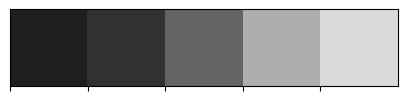

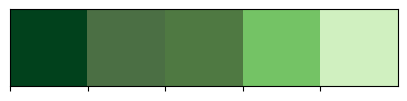

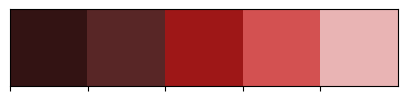

In [3]:
#Color definition for images
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
#Introducing labels in the dataset

dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

#### Loading training dataset

In [5]:
# Initialize lists
X_train = []
y_train = []
image_size = 150  # Resize all images to 150x150

# Load training images
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)  # Read the image
        if img is not None:  # Ensure image is loaded correctly
            img = cv2.resize(img, (image_size, image_size))  # Resize
            X_train.append(img)
            y_train.append(label)  # Store the label as a string

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")

Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 1045.90it/s]


Loaded 2870 images from the Training dataset.


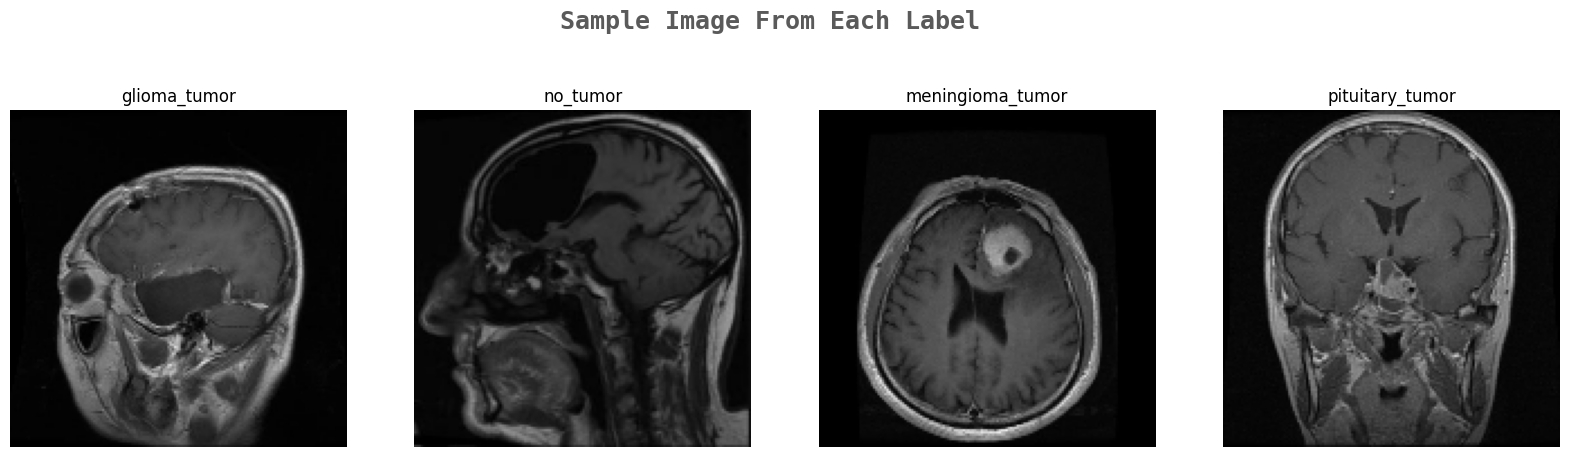

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
#Format test
print("Image shape:", X_train[0].shape)
print("Image data type:", X_train[0].dtype)


Image shape: (150, 150, 3)
Image data type: uint8


#### Convert BRG images into RGB as this is model requirement

In [8]:
X_train = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_train]


#### Data augmentation for no_tumor

We have much less data for healthy brain, so in order to have a balanced dataset we need to generate more no_tumor images through augmentation


In [9]:
# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
no_tumor_dir = os.path.join(train_dir, "no_tumor")
augmented_dir = os.path.join(train_dir, "no_tumor_augmented")

# Ensure the augmented directory exists
os.makedirs(augmented_dir, exist_ok=True)

# Augmentation settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.90, 1.10],
    width_shift_range=0.05,
    height_shift_range=0.05
)

# Use previously loaded no_tumor images
num_augmented = 425  # Target number of augmented images
count = 0

X_train = np.array(X_train)  # Ensure NumPy array
mask = np.array(y_train) == 'no_tumor'
X_no_tumor = X_train[mask]
for img in tqdm(X_no_tumor, desc="Generating augmented images"):
    img = np.expand_dims(img, axis=0)  # Reshape for ImageDataGenerator
    aug_iter = datagen.flow(img, batch_size=1)
    
    for _ in range(2):  # Generate 2 new images per original
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Convert back to uint8
        save_path = os.path.join(augmented_dir, f"aug_{count}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))  # Save as BGR
        count += 1
        
        if count >= num_augmented:
            break
    
    if count >= num_augmented:
        break

print(f"Generated {count} augmented images in {augmented_dir}")

Generating augmented images:  54%|█████▎    | 212/395 [00:01<00:01, 155.78it/s]

Generated 425 augmented images in /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented


#### Check the quality of augmented images

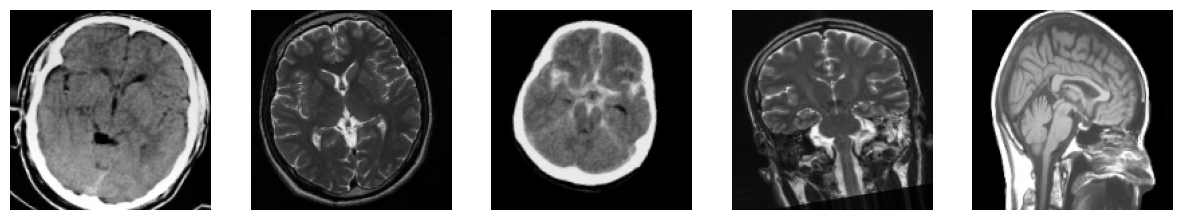

In [10]:
# Path to augmented images
augmented_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented"

# Get a list of augmented image files
augmented_files = os.listdir(augmented_dir)
random.shuffle(augmented_files)  # Shuffle to pick random images

# Display 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img_path = os.path.join(augmented_dir, augmented_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct display
    ax.imshow(img)
    ax.axis('off')

plt.show()


#### Integrate augmented data to training set

#### Integrate augmented data to training set

In [11]:
# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_dir = os.path.join(train_dir, "no_tumor_augmented")

# Load augmented images
augmented_images = []
augmented_labels = []

for filename in os.listdir(augmented_dir):
    img_path = os.path.join(augmented_dir, filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for consistency
        augmented_images.append(img)
        augmented_labels.append('no_tumor')  # Assign correct label

# Convert to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Append to training dataset
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print(f"Final dataset size after augmentation: {X_train.shape[0]} images")

Final dataset size after augmentation: 3295 images


#### Confirming class distribution after augmentation

In [12]:
# Define training directory
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"

# Define class subfolders
classes = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor_augmented"]

# Count images in each class
class_counts = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Merge 'no_tumor' and 'no_tumor_augmented'
if "no_tumor_augmented" in class_counts:
    class_counts["no_tumor"] += class_counts.pop("no_tumor_augmented")

# Print class distribution
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")


glioma_tumor: 826 images
no_tumor: 820 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


### Data preprocessing

In [13]:
#One-hot encoding of labels

# Encode class labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert to 0,1,2,3

# One-hot encode labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes=4)

# Print class mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Encoding Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [14]:
print(f"X_train shape: {X_train.shape}")  # Should be (N, 150, 150, 3)
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")  # Should be (N, 4)


X_train shape: (3295, 150, 150, 3)
y_train_one_hot shape: (3295, 4)


### Build the model building up on EfficientNetB0

#### Transfer learning

We use transfer learning, which means leveraging a pre-trained model (EfficientNet) trained on a large dataset (ImageNet) and adapting it to our specific classification task.
EfficientNet models are trained on ImageNet, a massive dataset of over 14 million images across 1000 different categories (e.g., cats, dogs, cars). The model learns generic features like edges, shapes, textures, and patterns, which are transferable to other image classification tasks.

We used weights="imagenet", meaning the model's convolutional layers already had learned feature maps from millions of images. This prevents the need to train from scratch and allows us to reuse EfficientNet's feature extraction capabilities.

We set base_model.trainable = False, meaning the convolutional layers were not updated during training. This ensures that EfficientNet continues to extract high-quality features from our medical images without being altered by our relatively small dataset.

Since EfficientNet was trained for 1000 classes, we needed to replace the top layers with a new classifier for our 4 tumor classes.

We added:
- GlobalAveragePooling2D() → Converts the final feature map into a 1D vector
- Dense(128, activation="relu") → A fully connected layer to learn new patterns.
- Dropout(0.5) → Prevents overfitting.
- Dense(4, activation="softmax") → The final output layer with 4 neurons (one for each class), using softmax activation for probability outputs.

In [15]:
# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB0 WITH ImageNet weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model(input_layer)

# Freeze base model layers
base_model.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])
# TensorFlow's Adam optimizer automatically uses learning_rate=0.001.
# Model summary
model.summary()


2025-02-06 15:13:36.618767: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-06 15:13:36.618936: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-06 15:13:36.618944: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-06 15:13:36.619123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-06 15:13:36.619134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### Setting up callbacks

A callback is a set of functions to be applied at given stages of the training procedure. We use callbacks to get a view on internal states and statistics of the model during training to optimize training by monitoring progress, preventing overfitting, and adjusting learning rates. TensorBoard logs training metrics, while ModelCheckpoint saves only the best model based on validation loss. ReduceLROnPlateau lowers the learning rate when validation loss stagnates, using a factor of 0.1, a patience of 3 epochs, and a minimum learning rate of 1e-6 to fine-tune learning. EarlyStopping halts training if validation loss doesn’t improve for 5 epochs and restores the best weights to avoid overfitting. These parameters ensure efficient training while maintaining model performance.

In [16]:
# TensorBoard - Logs training details
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# ModelCheckpoint - Saves the best model
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.h5",  # Save the best model
    monitor="val_loss",        # Track validation loss
    save_best_only=True,       # Save only when the model improves
    verbose=1
)

# ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",        # Watch validation loss
    factor=0.1,                # Reduce LR by 10x
    patience=3,                # Wait 3 epochs before reducing LR
    min_lr=1e-6,               # Do not reduce LR below this value
    verbose=1
)

# Combine all callbacks
callbacks = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks.append(early_stopping)


#### Split training dataset into training and validation

In [17]:
# Convert one-hot labels to class labels for stratified splitting
y_train_labels = np.argmax(y_train_one_hot, axis=1)

# Split the dataset (80% train, 20% validation)
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(
    X_train, y_train_labels, test_size=0.2, random_state=42, stratify=y_train_labels
)

# Convert back to one-hot encoding
y_train_balanced_one_hot = tf.keras.utils.to_categorical(y_train_balanced, num_classes=4)
y_val_balanced_one_hot = tf.keras.utils.to_categorical(y_val_balanced, num_classes=4)

# Print shapes and validation distribution
print(f"Balanced Training set: {X_train_balanced.shape}, {y_train_balanced_one_hot.shape}")
print(f"Balanced Validation set: {X_val_balanced.shape}, {y_val_balanced_one_hot.shape}")

# Check the class distribution in the balanced validation set
unique, counts = np.unique(y_val_balanced, return_counts=True)
print("Balanced Validation Set Class Distribution:", dict(zip(unique, counts)))


Balanced Training set: (2636, 150, 150, 3), (2636, 4)
Balanced Validation set: (659, 150, 150, 3), (659, 4)
Balanced Validation Set Class Distribution: {0: 165, 1: 164, 2: 164, 3: 166}


### Training the model

In [18]:
# Train the model with balanced datasets
history = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20


2025-02-06 15:13:40.340223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5886 - loss: 1.0014 - precision: 0.6405 - recall: 0.5106
Epoch 1: val_loss improved from inf to 0.49851, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.5896 - loss: 0.9990 - precision: 0.6416 - recall: 0.5121 - val_accuracy: 0.8073 - val_loss: 0.4985 - val_precision: 0.8288 - val_recall: 0.7936 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7968 - loss: 0.5432 - precision: 0.8152 - recall: 0.7771
Epoch 2: val_loss improved from 0.49851 to 0.41940, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.7968 - loss: 0.5433 - precision: 0.8152 - recall: 0.7771 - val_accuracy: 0.8483 - val_loss: 0.4194 - val_precision: 0.8607 - val_recall: 0.8346 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8070 - loss: 0.5069 - precision: 0.8286 - recall: 0.7934
Epoch 3: val_loss improved from 0.41940 to 0.40011, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8071 - loss: 0.5066 - precision: 0.8287 - recall: 0.7935 - val_accuracy: 0.8437 - val_loss: 0.4001 - val_precision: 0.8616 - val_recall: 0.8316 - learning_rate: 0.0010
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8517 - loss: 0.3962 - precision: 0.8609 - recall: 0.8351
Epoch 4: val_loss improved from 0.40011 to 0.37847, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.8516 - loss: 0.3964 - precision: 0.8608 - recall: 0.8350 - val_accuracy: 0.8619 - val_loss: 0.3785 - val_precision: 0.8807 - val_recall: 0.8513 - learning_rate: 0.0010
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8387 - loss: 0.4220 - precision: 0.8478 - recall: 0.8258
Epoch 5: val_loss improved from 0.37847 to 0.37288, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8390 - loss: 0.4213 - precision: 0.8481 - recall: 0.8260 - val_accuracy: 0.8756 - val_loss: 0.3729 - val_precision: 0.8837 - val_recall: 0.8649 - learning_rate: 0.0010
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8898 - loss: 0.3026 - precision: 0.8994 - recall: 0.8762
Epoch 6: val_loss improved from 0.37288 to 0.35269, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8896 - loss: 0.3030 - precision: 0.8993 - recall: 0.8761 - val_accuracy: 0.8680 - val_loss: 0.3527 - val_precision: 0.8806 - val_recall: 0.8619 - learning_rate: 0.0010
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8648 - loss: 0.3396 - precision: 0.8749 - recall: 0.8529
Epoch 7: val_loss did not improve from 0.35269
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8649 - loss: 0.3393 - precision: 0.8750 - recall: 0.8531 - val_accuracy: 0.8801 - val_loss: 0.3593 - val_precision: 0.8889 - val_recall: 0.8741 - learning_rate: 0.0010
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8890 - loss: 0.2945 - precision: 0.8968 - recall: 0.8775
Epoch 8: val_loss improved from 0.35269 to 0.33798, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.8890 - loss: 0.2946 - precision: 0.8968 - recall: 0.8776 - val_accuracy: 0.8786 - val_loss: 0.3380 - val_precision: 0.8814 - val_recall: 0.8680 - learning_rate: 0.0010
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8994 - loss: 0.2955 - precision: 0.9089 - recall: 0.8939
Epoch 9: val_loss did not improve from 0.33798
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.8993 - loss: 0.2954 - precision: 0.9088 - recall: 0.8939 - val_accuracy: 0.8847 - val_loss: 0.3390 - val_precision: 0.8911 - val_recall: 0.8816 - learning_rate: 0.0010
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8809 - loss: 0.2897 - precision: 0.8939 - recall: 0.8744
Epoch 10: val_loss improved from 0.33798 to 0.33296, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8811 - loss: 0.2895 - precision: 0.8940 - recall: 0.8745 - val_accuracy: 0.8756 - val_loss: 0.3330 - val_precision: 0.8814 - val_recall: 0.8680 - learning_rate: 0.0010
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9028 - loss: 0.2567 - precision: 0.9148 - recall: 0.8973
Epoch 11: val_loss improved from 0.33296 to 0.31117, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9028 - loss: 0.2568 - precision: 0.9148 - recall: 0.8973 - val_accuracy: 0.8923 - val_loss: 0.3112 - val_precision: 0.8974 - val_recall: 0.8892 - learning_rate: 0.0010
Epoch 12/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9013 - loss: 0.2579 - precision: 0.9039 - recall: 0.8918
Epoch 12: val_loss did not improve from 0.31117
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9013 - loss: 0.2577 - precision: 0.9040 - recall: 0.8919 - val_accuracy: 0.8938 - val_loss: 0.3209 - val_precision: 0.8997 - val_recall: 0.8847 - learning_rate: 0.0010
Epoch 13/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9067 - loss: 0.2427 - precision: 0.9128 - recall: 0.9015
Epoch 13: val_loss did not improve from 0.31117
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9067 - loss: 0.2429 - precision: 0.9127 - recall: 0.9014 - val_accuracy: 0.8741 - val_loss: 0.3267 - val_precision: 0.8827 - val_recall: 0.8680 - learning_rate:

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9073 - loss: 0.2404 - precision: 0.9121 - recall: 0.8966 - val_accuracy: 0.8953 - val_loss: 0.2971 - val_precision: 0.8976 - val_recall: 0.8907 - learning_rate: 1.0000e-04
Epoch 16/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9041 - loss: 0.2369 - precision: 0.9084 - recall: 0.8963
Epoch 16: val_loss improved from 0.29706 to 0.29480, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9043 - loss: 0.2367 - precision: 0.9085 - recall: 0.8965 - val_accuracy: 0.8968 - val_loss: 0.2948 - val_precision: 0.9034 - val_recall: 0.8938 - learning_rate: 1.0000e-04
Epoch 17/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9181 - loss: 0.2073 - precision: 0.9243 - recall: 0.9126
Epoch 17: val_loss improved from 0.29480 to 0.29218, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9182 - loss: 0.2073 - precision: 0.9244 - recall: 0.9126 - val_accuracy: 0.9014 - val_loss: 0.2922 - val_precision: 0.9037 - val_recall: 0.8968 - learning_rate: 1.0000e-04
Epoch 18/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9316 - loss: 0.2092 - precision: 0.9361 - recall: 0.9265
Epoch 18: val_loss did not improve from 0.29218
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9316 - loss: 0.2091 - precision: 0.9361 - recall: 0.9265 - val_accuracy: 0.8983 - val_loss: 0.2925 - val_precision: 0.9018 - val_recall: 0.8923 - learning_rate: 1.0000e-04
Epoch 19/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9204 - loss: 0.2099 - precision: 0.9291 - recall: 0.9178
Epoch 19: val_loss improved from 0.29218 to 0.29195, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9204 - loss: 0.2099 - precision: 0.9292 - recall: 0.9179 - val_accuracy: 0.8968 - val_loss: 0.2920 - val_precision: 0.9003 - val_recall: 0.8907 - learning_rate: 1.0000e-04
Epoch 20/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9340 - loss: 0.1774 - precision: 0.9394 - recall: 0.9299
Epoch 20: val_loss did not improve from 0.29195
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9340 - loss: 0.1775 - precision: 0.9394 - recall: 0.9299 - val_accuracy: 0.8983 - val_loss: 0.2950 - val_precision: 0.9037 - val_recall: 0.8968 - learning_rate: 1.0000e-04


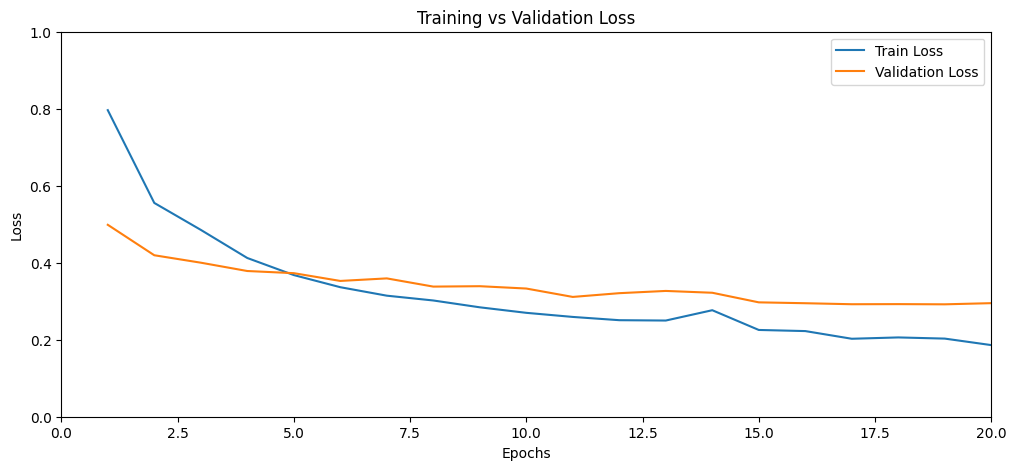

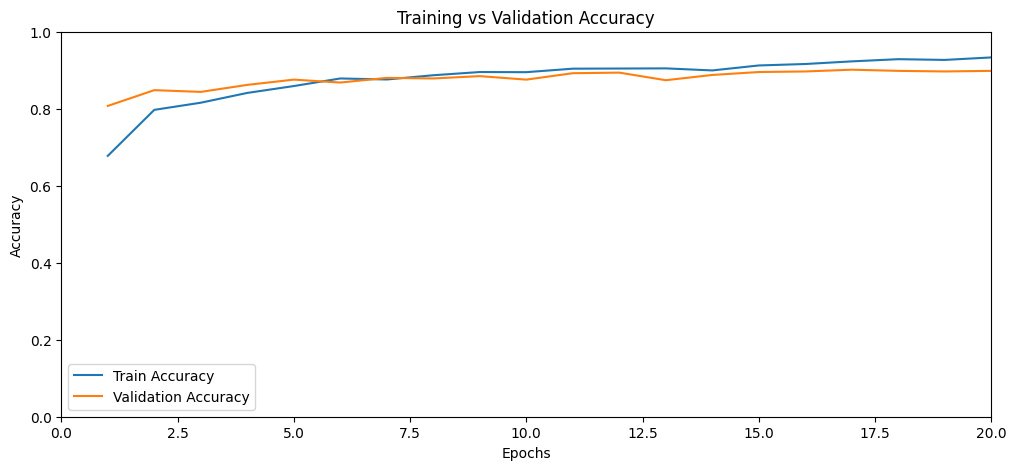

In [19]:
epochs = range(1, len(history.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history.history["loss"], label="Train Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()



In [20]:
# Get predictions from the model (on validation or test set)
pred = model.predict(X_val_balanced)  # Change to X_test if you want to evaluate on the test set

# Convert predictions from one-hot to class labels
pred_labels = np.argmax(pred, axis=1)

# If you want to evaluate on validation set, use y_val_balanced (or y_test for test data)
y_true_labels = np.argmax(y_val_balanced_one_hot, axis=1)

# Print classification report
print(classification_report(y_true_labels, pred_labels))


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       165
           1       0.80      0.82      0.81       164
           2       0.94      0.97      0.95       164
           3       0.93      0.97      0.95       166

    accuracy                           0.90       659
   macro avg       0.90      0.90      0.90       659
weighted avg       0.90      0.90      0.90       659



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


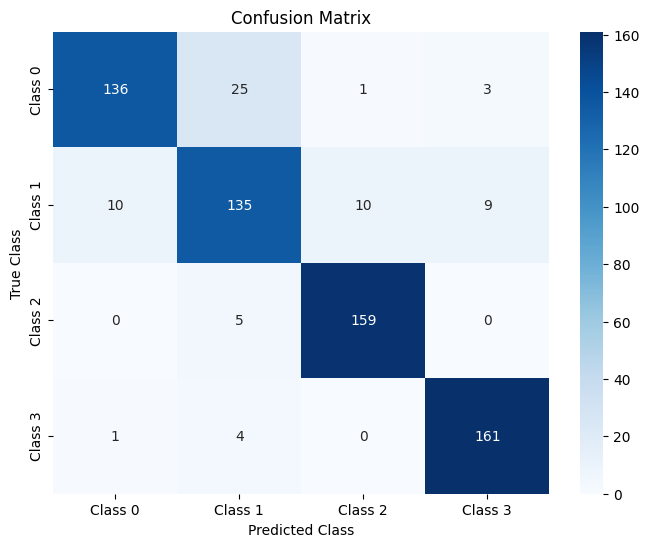

In [21]:
# Predict on validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_val_balanced_one_hot, axis=1), y_pred_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


In [22]:
#Saving best performing model before fine-tuning
model.save("true_best_model.keras")

### Results 

#### Overall Performance:

The model achieved 90% accuracy. The macro average precision, recall, and F1-score are all 0.90, showing balanced performance across classes.

**Loss and Accuracy Plots:**

Training and validation loss steadily decrease, which means the model is still learning without major signs of overfitting.
Training and validation accuracy are close, which is a very good sign—no major overfitting or underfitting.

**Class-Wise Breakdown:**

**Class 0 (Glioma Tumor):** Precision: 0.92 (very high, meaning fewer false positives). Recall: 0.82 (lower compared to others, meaning some false negatives exist). This class has lower recall, so the model misses more glioma cases.

**Class 1 (Meningioma Tumor):** Balanced precision (0.80) and recall (0.82), meaning it's performing equally in detecting and avoiding false alarms.

**Class 2 (No Tumor):** Highest recall (0.98) → almost no false negatives. Highest precision (0.94) → almost no false positives. This class is classified extremely well. Maybe because we augmented data here?

**Class 3 (Pituitary Tumor):** High recall (0.96) and precision (0.92). The model does well in correctly detecting pituitary tumors.

### Fine-tuning: Try to increase model performance by unfreezing a few layers

In [23]:
# Unfreeze the last 10 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Keep earlier layers frozen
    layer.trainable = False

# Re-compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Fine-Tune the model
history_finetune = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    epochs=10,  # Fine-tune for 10 more epochs
    batch_size=32,
    callbacks=callbacks,  # EarlyStopping should be included
    verbose=1
)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8855 - loss: 0.3446 - precision_1: 0.8953 - recall_1: 0.8745
Epoch 1: val_loss improved from 0.29195 to 0.29160, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.8855 - loss: 0.3445 - precision_1: 0.8953 - recall_1: 0.8746 - val_accuracy: 0.8847 - val_loss: 0.2916 - val_precision_1: 0.8896 - val_recall_1: 0.8801 - learning_rate: 1.0000e-05
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8854 - loss: 0.3091 - precision_1: 0.8925 - recall_1: 0.8808
Epoch 2: val_loss did not improve from 0.29160
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.8855 - loss: 0.3088 - precision_1: 0.8926 - recall_1: 0.8809 - val_accuracy: 0.8816 - val_loss: 0.3038 - val_precision_1: 0.8860 - val_recall_1: 0.8725 - learning_rate: 1.0000e-05
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8993 - loss: 0.2697 - precision_1: 0.9067 - recall_1: 0.8918
Epoch 3: val_loss did not improve from 0.29160
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8993 - loss: 0.2695 - precision_1: 0.9067 - recall_1: 0.8918 - val_accuracy: 0.8786 - val_loss: 0.3154 - val_precision_1: 0.8875

In [24]:
# Get predictions for validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_balanced_one_hot, axis=1)

# Print Classification Report (Fine-Tuning Results)
print("Classification Report After Fine-Tuning:")
print(classification_report(y_true, y_pred_classes))

# Compute and print Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix After Fine-Tuning:")
print(conf_matrix)


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 327ms/step
Classification Report After Fine-Tuning:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       165
           1       0.78      0.79      0.79       164
           2       0.92      0.98      0.95       164
           3       0.94      0.93      0.94       166

    accuracy                           0.88       659
   macro avg       0.88      0.88      0.88       659
weighted avg       0.89      0.88      0.88       659

Confusion Matrix After Fine-Tuning:
[[138  25   1   1]
 [ 14 130  12   8]
 [  0   3 161   0]
 [  2   9   1 154]]


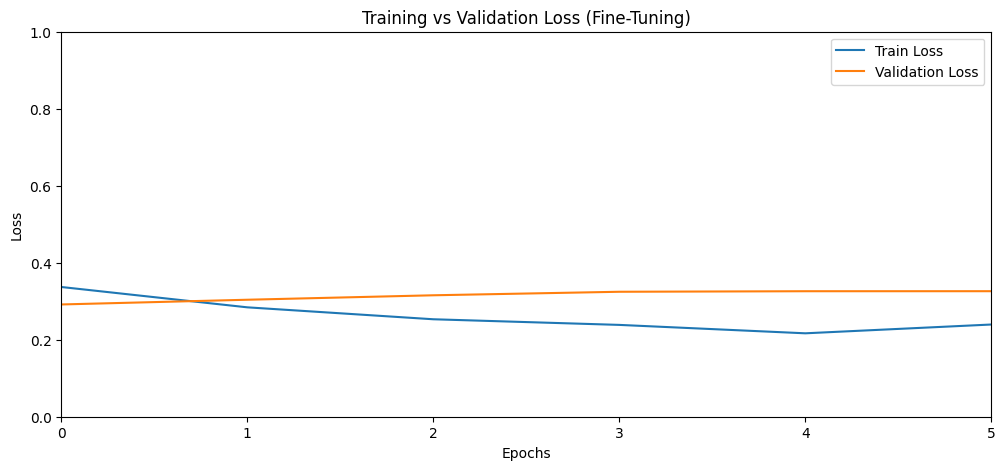

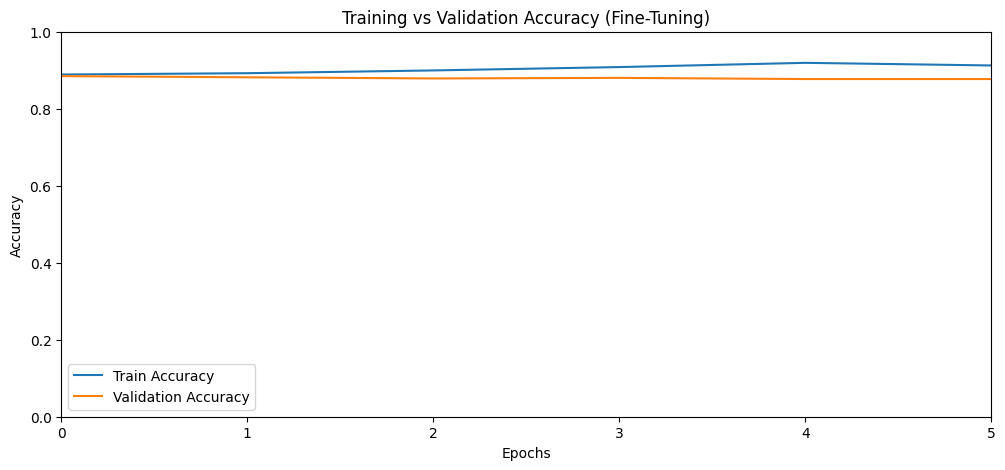

In [25]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(range(len(history_finetune.history["loss"])), history_finetune.history["loss"], label="Train Loss")
plt.plot(range(len(history_finetune.history["val_loss"])), history_finetune.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Fine-Tuning)")
plt.xlim(0, max(range(len(history_finetune.history["loss"]))))
plt.ylim(0, 1)  # Start y-axis from 0
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(len(history_finetune.history["accuracy"])), history_finetune.history["accuracy"], label="Train Accuracy")
plt.plot(range(len(history_finetune.history["val_accuracy"])), history_finetune.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (Fine-Tuning)")
plt.xlim(0, max(range(len(history_finetune.history["accuracy"]))))
plt.ylim(0, 1)  # Start y-axis from 0
plt.show()


In [26]:
# Keep the fine-tuned model and reduce the learning rate further
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Fine-tune with even smaller learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Continue Fine-Tuning (EarlyStopping will determine when to stop)
history_finetune2 = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  # Uses EarlyStopping
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9077 - loss: 0.2543 - precision_2: 0.9136 - recall_2: 0.8990
Epoch 1: val_loss did not improve from 0.29160
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 268ms/step - accuracy: 0.9077 - loss: 0.2544 - precision_2: 0.9135 - recall_2: 0.8989 - val_accuracy: 0.8801 - val_loss: 0.3156 - val_precision_2: 0.8877 - val_recall_2: 0.8756 - learning_rate: 1.0000e-06


In [27]:
# Get predictions for validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_balanced_one_hot, axis=1)

# Print Classification Report
print("Classification Report After Second Fine-Tuning:")
print(classification_report(y_true, y_pred_classes))

# Compute and print Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix After Second Fine-Tuning:")
print(conf_matrix)


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 558ms/step
Classification Report After Second Fine-Tuning:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       165
           1       0.77      0.79      0.78       164
           2       0.92      0.98      0.95       164
           3       0.93      0.93      0.93       166

    accuracy                           0.88       659
   macro avg       0.88      0.88      0.88       659
weighted avg       0.88      0.88      0.88       659

Confusion Matrix After Second Fine-Tuning:
[[136  26   1   2]
 [ 14 129  12   9]
 [  0   4 160   0]
 [  2   8   1 155]]


### It did not improve the performance, try to reload best performing model and fine-tune again

In [28]:
model_finetune_v3 = load_model("true_best_model.keras")

# Confirm the model is restored correctly
eval_restored = model_finetune_v3.evaluate(X_val_balanced, y_val_balanced_one_hot, verbose=1)

print(f"Restored Model Evaluation (Before Fine-Tuning):")
print(f" - Loss: {eval_restored[0]:.4f}")
print(f" - Accuracy: {eval_restored[1]:.4f}")
print(f" - Precision: {eval_restored[2]:.4f}")
print(f" - Recall: {eval_restored[3]:.4f}")


/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.9055 - loss: 0.2822 - precision: 0.9078 - recall: 0.9003
Restored Model Evaluation (Before Fine-Tuning):
 - Loss: 0.2920
 - Accuracy: 0.8968
 - Precision: 0.9003
 - Recall: 0.8907


In [29]:
# Unfreeze the last 10 layers 
model_finetune_v3.trainable = True
for layer in model_finetune_v3.layers[:-10]:  
    layer.trainable = False  # Keep earlier layers frozen

# Lower the learning rate to prevent destabilization
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)


In [30]:
# Unfreeze the last 20 layers for fine-tuning
base_model_v3 = model_finetune_v3.get_layer("efficientnetb0")
base_model_v3.trainable = True

for layer in base_model_v3.layers[:-20]:  
    layer.trainable = False  # Keep earlier layers frozen

# Recompile with a lower learning rate
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)


In [31]:
history_finetune_v3 = model_finetune_v3.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7950 - loss: 0.6134 - precision_4: 0.8124 - recall_4: 0.7763
Epoch 1: val_loss did not improve from 0.29160
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 394ms/step - accuracy: 0.7953 - loss: 0.6122 - precision_4: 0.8126 - recall_4: 0.7766 - val_accuracy: 0.8634 - val_loss: 0.3754 - val_precision_4: 0.8710 - val_recall_4: 0.8604 - learning_rate: 2.0000e-05


In [32]:
# Unfreeze the last 15 layers instead of 10
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-15]:  
    layer.trainable = False  # Keep earlier layers frozen

# Switch to SGD with momentum for smoother fine-tuning
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train again with updated settings
history_finetune_v3 = model_finetune_v3.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8481 - loss: 0.3968 - precision_5: 0.8647 - recall_5: 0.8372
Epoch 1: val_loss did not improve from 0.29160
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 338ms/step - accuracy: 0.8482 - loss: 0.3966 - precision_5: 0.8647 - recall_5: 0.8373 - val_accuracy: 0.8376 - val_loss: 0.4277 - val_precision_5: 0.8462 - val_recall_5: 0.8346 - learning_rate: 2.0000e-05


In [33]:
# Unfreeze last 15 layers for fine-tuning
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-15]:  
    layer.trainable = False  # Keep earlier layers frozen

# Apply stronger dropout without breaking the model
x = model_finetune_v3.layers[-3].output  # Take existing last hidden layer
x = Dropout(0.6)(x)  # Apply dropout
output_layer = model_finetune_v3.layers[-1](x)  # Keep the same output layer

# Create the corrected fine-tuned model
model_finetune_v4 = Model(inputs=model_finetune_v3.input, outputs=output_layer)

# Compile the model
model_finetune_v4.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train again
history_finetune_v4 = model_finetune_v4.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8417 - loss: 0.3837 - precision_6: 0.8584 - recall_6: 0.8315
Epoch 1: val_loss did not improve from 0.29160
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 331ms/step - accuracy: 0.8417 - loss: 0.3838 - precision_6: 0.8584 - recall_6: 0.8316 - val_accuracy: 0.8316 - val_loss: 0.4650 - val_precision_6: 0.8361 - val_recall_6: 0.8285 - learning_rate: 2.0000e-05


### Fine-Tuning Is Likely Causing Overfitting

- Training accuracy keeps increasing (~92%), but validation accuracy does not improve (~86%) → This suggests the model is memorizing training data without generalizing better.

- Validation loss (0.3608) is still worse than the original model (0.2831) → Normally, fine-tuning should lower validation loss. Since it's increasing, the model is learning features that do not transfer well to validation data.

- Fine-tuning increases the number of trainable parameters, which can cause overfitting if the dataset is not large enough. Since we unfreeze more layers, the model can learn too many small details that don’t generalize well.

- Precision is improving slightly, but recall is stuck, meaning the model is getting more confident about predictions but is not recognizing all correct cases, which is a sign of overfitting to training data.

Since fine-tuning did not improve performance, we will evaluate the original model on the test set.

### Evaluate the original model on the test set.

In [34]:
# Load the best original model
model = load_model("true_best_model.keras")

# Confirm it’s the correct model
eval_check = model.evaluate(X_val_balanced, y_val_balanced_one_hot, verbose=1)

print(f"Restored Model Evaluation (Before Fine-Tuning):")
print(f" - Loss: {eval_restored[0]:.4f}")
print(f" - Accuracy: {eval_restored[1]:.4f}")
print(f" - Precision: {eval_restored[2]:.4f}")
print(f" - Recall: {eval_restored[3]:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.9055 - loss: 0.2822 - precision: 0.9078 - recall: 0.9003
Restored Model Evaluation (Before Fine-Tuning):
 - Loss: 0.2920
 - Accuracy: 0.8968
 - Precision: 0.9003
 - Recall: 0.8907


In [35]:
# Define test dataset path
test_dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialize lists for images and labels
X_test = []
y_test = []

# Load images from test dataset
for label_index, label in enumerate(labels):
    label_path = os.path.join(test_dataset_path, label)
    for filename in os.listdir(label_path):
        img_path = os.path.join(label_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (150, 150))  # 🔥 Ensure all images are (150,150)
            X_test.append(img)
            y_test.append(label_index)  # Assign label index

# Convert to NumPy arrays
X_test = np.array(X_test, dtype="float32")
y_test = np.array(y_test)

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=4)

# Print dataset size
print(f" Test dataset loaded successfully: {X_test.shape[0]} images")


 Test dataset loaded successfully: 394 images


In [36]:
# Check unique shapes in X_test
shapes = set(img.shape for img in X_test)
print("Unique image shapes in test set:", shapes)


Unique image shapes in test set: {(150, 150, 3)}


In [37]:
# Count occurrences of each label in the test set
test_class_distribution = collections.Counter(y_test)

# Map indices back to class names
test_class_distribution_named = {labels[k]: v for k, v in test_class_distribution.items()}

print("Test Dataset Class Distribution:", test_class_distribution_named)


Test Dataset Class Distribution: {'glioma_tumor': 100, 'no_tumor': 105, 'meningioma_tumor': 115, 'pituitary_tumor': 74}


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 885ms/step - accuracy: 0.1486 - loss: 4.9807 - precision: 0.1559 - recall: 0.1473

Test Set Evaluation:
 - Loss: 4.4838
 - Accuracy: 0.2487
 - Precision: 0.2559
 - Recall: 0.2462
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step 

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.17      0.29       100
        no_tumor       0.01      0.02      0.01       105
meningioma_tumor       0.08      0.10      0.09       115
 pituitary_tumor       0.89      0.92      0.91        74

        accuracy                           0.25       394
       macro avg       0.48      0.30      0.32       394
    weighted avg       0.43      0.25      0.27       394



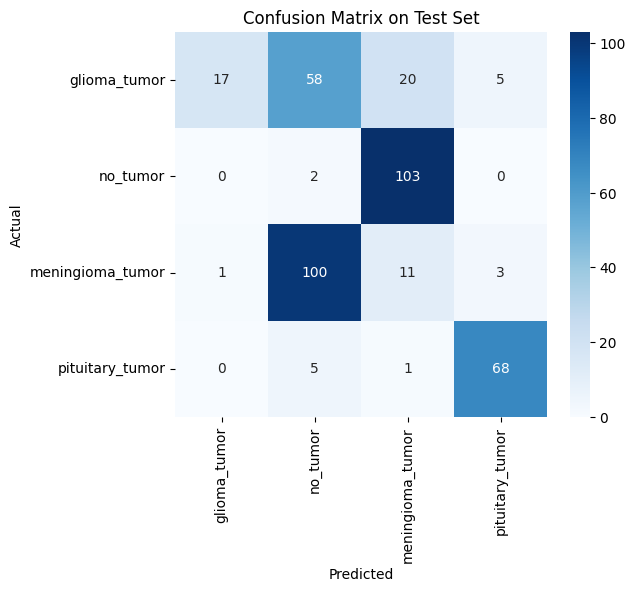

In [38]:
# Evaluate model on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test_one_hot, verbose=1)

print(f"\nTest Set Evaluation:")
print(f" - Loss: {test_loss:.4f}")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test_one_hot, axis=1)  

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Results 

- Glioma tumors are mostly misclassified as "no tumor" (54 cases).
- Meningioma tumors are also misclassified as "no tumor" (103 cases).
- Pituitary tumors are well classified, with 69 out of 74 correctly predicted

Since the model performs well on the training and validation sets but fails on the test set, the issue is likely domain shift—the test images differ in some way from the training data. Possible ways to approach it: 

-Analyze Differences Between Training and Test Images

Check if test images have different contrast, brightness, or resolution.
Compare histograms of pixel intensity distributions.

- Modify Data Augmentation to Match Test Set Better

If test images have more noise or lower contrast, introduce similar distortions in training.
Try contrast normalization or adaptive histogram equalization.


We want to again visually inspect example images to see if there is obvious reason for misclassification.

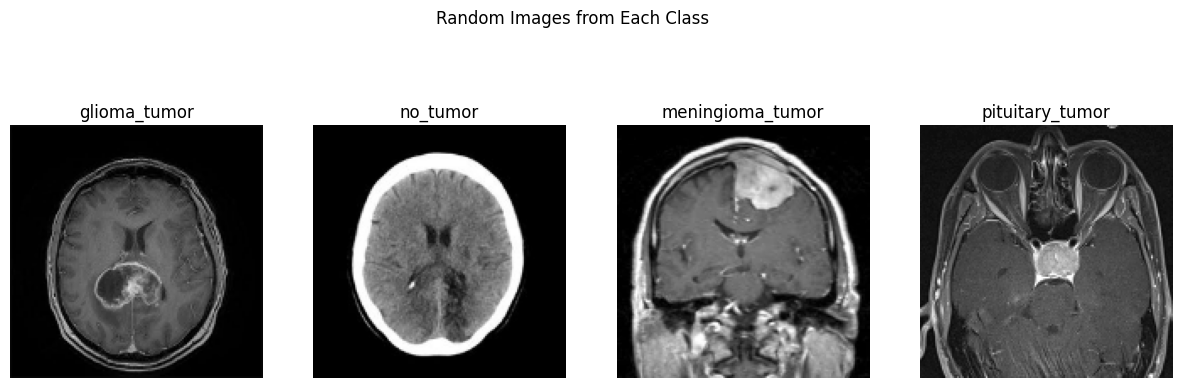

In [39]:
# Define class labels
class_labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Create a figure
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Random Images from Each Class")

# Select one random image from each class
for i, label in enumerate(class_labels):
    indices = [idx for idx, lbl in enumerate(y_test) if lbl == i]
    random_idx = random.choice(indices)
    
    axes[i].imshow(X_test[random_idx].astype("uint8"))  # Convert back to uint8 for display
    axes[i].set_title(label)
    axes[i].axis("off")

plt.show()


### Troubleshooting

#### Analyze Differences Between Training and Test Images

We compare histograms of pixel intensity distributions for each dataset to see if the test set has a different contrast or brightness distribution.

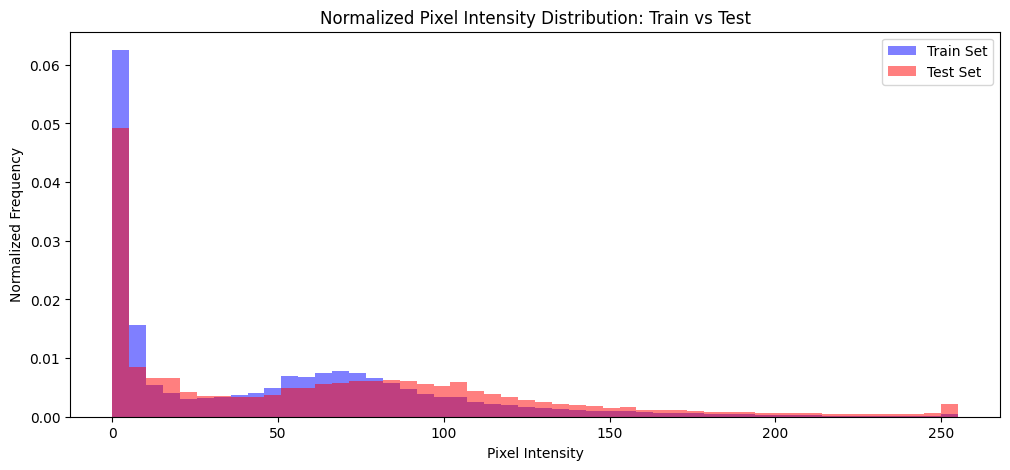

In [40]:
# Convert images to grayscale
X_train_gray = np.mean(X_train, axis=-1)
X_test_gray = np.mean(X_test, axis=-1)

# Flatten pixel values
train_pixels = X_train_gray.flatten()
test_pixels = X_test_gray.flatten()

plt.figure(figsize=(12, 5))
plt.hist(train_pixels, bins=50, alpha=0.5, color='blue', label='Train Set', density=True)
plt.hist(test_pixels, bins=50, alpha=0.5, color='red', label='Test Set', density=True)
plt.xlabel("Pixel Intensity")
plt.ylabel("Normalized Frequency")
plt.title("Normalized Pixel Intensity Distribution: Train vs Test")
plt.legend()
plt.show()


They look similar overall, except for slightly higher intensity frequencies in the test set at lower values. This suggests:

No extreme shifts in brightness or contrast, meaning the test set isn't drastically different.
The train set has a slightly higher proportion of very low-intensity pixels, which could indicate different preprocessing steps between datasets.


#### Next step: Visualize some test set misclassifications (plot original image + predicted vs actual labels).

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


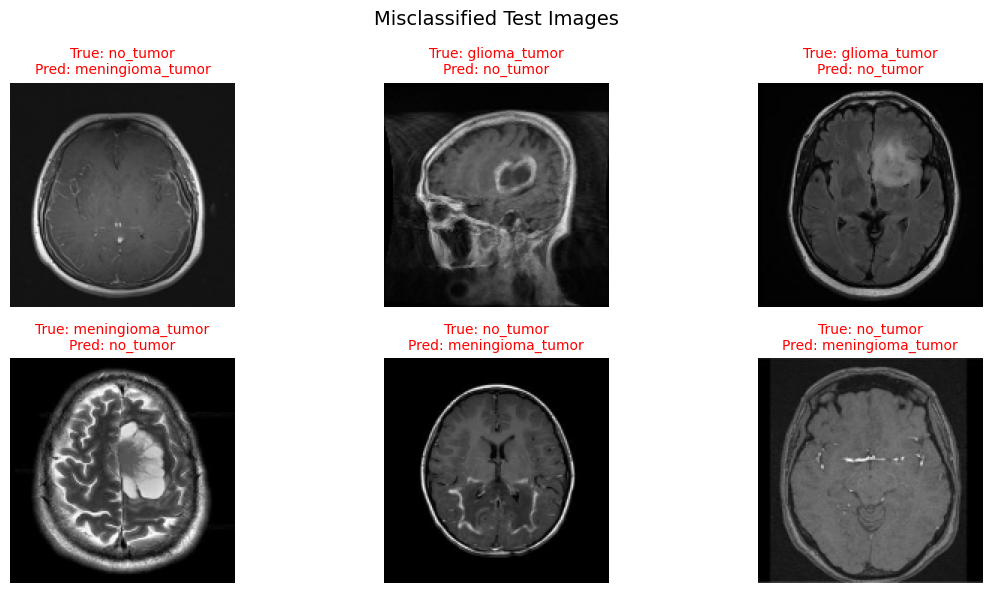

In [41]:
# Ensure model is defined and X_test is properly formatted
assert 'model' in globals(), "Error: Model not found in memory."
assert isinstance(X_test, np.ndarray), "Error: X_test is not a NumPy array."
assert isinstance(y_test, np.ndarray), "Error: y_test is not a NumPy array."

# Get model predictions
y_pred = model.predict(X_test)  

# Check if predictions are correctly shaped
assert len(y_pred.shape) == 2, f"Error: Expected (num_samples, num_classes), got {y_pred.shape}"
assert y_pred.shape[0] == y_test.shape[0], "Error: Mismatch between y_pred and y_test samples."

# Convert probabilities to label indices
y_pred_labels = np.argmax(y_pred, axis=1)  

# Ensure y_test is in label form (not one-hot encoded)
if len(y_test.shape) > 1:  
    y_test_labels = np.argmax(y_test, axis=1)  
else:
    y_test_labels = y_test  

# Identify misclassified images
misclassified_indices = np.where(y_pred_labels != y_test_labels)[0]

# Ensure there are misclassified samples to display
assert len(misclassified_indices) > 0, "No misclassified samples found."

# Select a few misclassified samples to display
num_images = min(6, len(misclassified_indices))
misclassified_samples = np.random.choice(misclassified_indices, num_images, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(misclassified_samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx].astype("uint8"), cmap="gray")  
    plt.axis("off")
    actual_label = labels[y_test_labels[idx]]
    predicted_label = labels[y_pred_labels[idx]]
    plt.title(f"True: {actual_label}\nPred: {predicted_label}", fontsize=10, color="red")

plt.suptitle("Misclassified Test Images", fontsize=14)
plt.tight_layout()
plt.show()


The model struggles mainly with meningioma, no_tumor, and glioma misclassifications. The patterns suggest:

Meningioma vs. Pituitary: Some meningiomas are classified as pituitary tumors, possibly due to similar tumor locations near the brainstem.
No Tumor vs. Meningioma: The model confuses normal brain images with meningioma cases, likely due to subtle texture differences.
Glioma vs. No Tumor: Some gliomas appear as "no tumor," possibly indicating low contrast or diffuse growth patterns.

In [42]:
test_dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"
categories = [folder for folder in os.listdir(test_dataset_path) if not folder.startswith(".")]
print("Test dataset categories:", categories)


Test dataset categories: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']


In [43]:
for label in categories:
    label_path = os.path.join(test_dataset_path, label)
    print(f"{label}: {len(os.listdir(label_path))} images")


no_tumor: 105 images
meningioma_tumor: 115 images
glioma_tumor: 100 images
pituitary_tumor: 74 images


In [44]:
corrupt_files = []
for label in categories:
    label_path = os.path.join(test_dataset_path, label)
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if it's a readable image
        except Exception as e:
            corrupt_files.append(file_path)

# Output results
if corrupt_files:
    print("Corrupt images detected:")
    for f in corrupt_files:
        print(f)
else:
    print(" No corrupt images found.")


 No corrupt images found.


In [45]:
for label in categories:
    label_path = os.path.join(test_dataset_path, label)
    print(f"{label}: {len(os.listdir(label_path))} images")


no_tumor: 105 images
meningioma_tumor: 115 images
glioma_tumor: 100 images
pituitary_tumor: 74 images


In [46]:

print("Test Labels Distribution:", Counter(y_test))


Test Labels Distribution: Counter({2: 115, 1: 105, 0: 100, 3: 74})


In [47]:

print("Predicted Labels Distribution:", Counter(y_pred_labels))


Predicted Labels Distribution: Counter({1: 165, 2: 135, 3: 76, 0: 18})


# Part 2

### Improving the model preditions

Since we confirmed domain gap and the model is confidently misclassifying test images, let's fix it using contrast-specific augmentation to make the model more robust. We want to retrain from scratch with augmentation of the training images to ensure full generalization.

**Steps to Fix the Issue:**

- Apply Contrast & Brightness Augmentation
This will make the model learn from a wider range of image intensities, reducing overfitting.

- Retrain the Model With Augmented Data
Train the same original model, but include random contrast & brightness variations.

In [48]:
# Get prediction probabilities
y_pred_prob = model.predict(X_test)

# Compute average confidence
avg_confidence = y_pred_prob.max(axis=1).mean()
print(f"Average Confidence Score: {avg_confidence:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Average Confidence Score: 0.8872


The model has high confidence (0.89) but is making many incorrect predictions, confirming a domain gap issue. This means the model is very sure about wrong predictions, indicating it learned features that do not generalize to the test set.

What this means:
- Not a random guessing issue (low confidence would indicate uncertainty).
- The model is misclassifying test images confidently, meaning it's overfitting to training patterns.
- Test images likely differ in some way (contrast, texture, noise, etc.).



### Data preprocessing

Our first model struggles mainly with meningioma, no_tumor, and glioma misclassifications, one possibility is that Test images likely differ from Training set in some way (contrast, texture, noise, etc.).
To adress that we want to implement contrast-focused augmentation. 

Small rotations (±10°)
Horizontal flips
Slight brightness adjustments

In [49]:
# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Define augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
])

# Define classes to augment
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Ensure output directories exist
os.makedirs(augmented_train_dir, exist_ok=True)

for label in labels:
    class_dir = os.path.join(train_dir, label)
    augmented_class_dir = os.path.join(augmented_train_dir, label)

    os.makedirs(augmented_class_dir, exist_ok=True)

    # Load all images from the class
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_original = len(image_files)

    # Determine how many images to generate
    target_count = 2400
    num_to_generate = target_count - num_original

    # Copy original images first
    for filename in tqdm(image_files, desc=f"Copying {label}"):
        img_path = os.path.join(class_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            save_path = os.path.join(augmented_class_dir, filename)
            cv2.imwrite(save_path, img)

    # Augment only if needed
    if num_to_generate > 0:
        for i in tqdm(range(num_to_generate), desc=f"Generating for {label}"):
            img_path = os.path.join(class_dir, image_files[i % num_original])  # Cycle through original images
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for augmentation
                augmented = augmentation(image=img)["image"]
                save_path = os.path.join(augmented_class_dir, f"{label}_aug_{i+1}.png")
                cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("Augmentation complete. No_tumor_augmented was **excluded**.")


Generating for pituitary_tumor: 100%|██████████| 1573/1573 [00:09<00:00, 161.83it/s]

Augmentation complete. No_tumor_augmented was **excluded**.


In [50]:
# Path to augmented dataset
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Count images per class
final_counts = {label: len(os.listdir(os.path.join(augmented_train_dir, label))) for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]}

print("Final dataset distribution after balanced augmentation:")
for label, count in final_counts.items():
    print(f"{label}: {count} images")


Final dataset distribution after balanced augmentation:
glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


#### We want to visualise some example images after augmentation

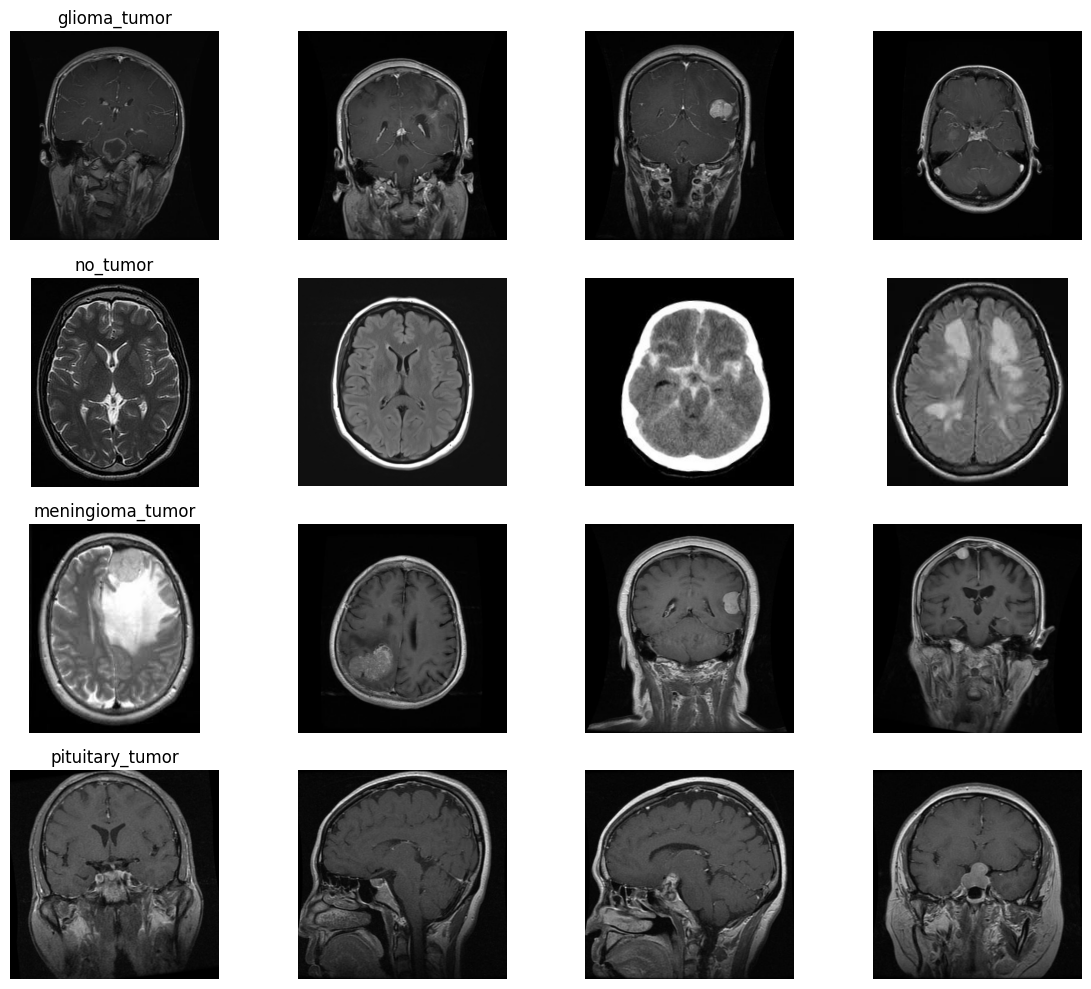

In [51]:
# Define path to augmented dataset
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Define class labels
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Number of images to display per class
num_images = 4  

# Display images
fig, axes = plt.subplots(len(labels), num_images, figsize=(12, 10))

for i, label in enumerate(labels):
    class_dir = os.path.join(augmented_train_dir, label)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select random images
    selected_files = random.sample(image_files, num_images)

    for j, file in enumerate(selected_files):
        img_path = os.path.join(class_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(label, fontsize=12)

plt.tight_layout()
plt.show()


In [52]:
# Paths
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Initialize lists
X_train_augmented = []
y_train_augmented = []

# Define class labels
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Load images from the augmented dataset
for label in labels:
    folder_path = os.path.join(augmented_train_dir, label)
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 2400:
        print(f"Warning: {label} has {len(image_files)} images instead of 2400!")

    for filename in tqdm(image_files, desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train_augmented.append(img)
            y_train_augmented.append(label)

# Convert lists to NumPy arrays
X_train_augmented = np.array(X_train_augmented, dtype=object)
y_train_augmented = np.array(y_train_augmented)

# Count class distribution
class_counts = Counter(y_train_augmented)

print(f"Final dataset size after reloading: {X_train_augmented.shape[0]} images")
print("Class distribution after reloading:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Loading pituitary_tumor: 100%|██████████| 2400/2400 [00:07<00:00, 322.09it/s]

Final dataset size after reloading: 9600 images
Class distribution after reloading:
glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


In [53]:

print("Final label distribution after augmentation:", Counter(y_train_augmented))


Final label distribution after augmentation: Counter({'glioma_tumor': 2400, 'no_tumor': 2400, 'meningioma_tumor': 2400, 'pituitary_tumor': 2400})


In [54]:
# Encode class labels as integers
label_encoder = LabelEncoder()
y_train_aug_encoded = label_encoder.fit_transform(y_train_augmented)  # Convert labels to integers

# One-hot encode labels
y_train_aug_one_hot = to_categorical(y_train_aug_encoded, num_classes=4)

# Print class mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Encoding Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [55]:
# Ensure all images are valid NumPy arrays before resizing
X_train_resized = np.array([cv2.resize(np.array(img, dtype=np.uint8), (150, 150)) for img in X_train_augmented], dtype=np.uint8)

# Confirm new shape
print("Resized dataset shape:", X_train_resized.shape)


Resized dataset shape: (9600, 150, 150, 3)


In [56]:
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]:
    class_dir = os.path.join(augmented_train_dir, label)
    print(f"{label}: {len(os.listdir(class_dir))} images")


glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


In [57]:
# Verify encoded label distribution
print("Final label distribution after encoding:", Counter(y_train_aug_encoded))


Final label distribution after encoding: Counter({0: 2400, 2: 2400, 1: 2400, 3: 2400})


### Build the model building up on EfficientNetB0

In [58]:
# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB0 WITH ImageNet weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model(input_layer)

# Freeze base model layers
base_model.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])
# TensorFlow's Adam optimizer automatically uses learning_rate=0.001.
# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [59]:
# Create logs directory
log_dir_NB2 = "./logs_NB2"
os.makedirs(log_dir_NB2, exist_ok=True)

# TensorBoard - Logs training details
tensorboard_NB2 = TensorBoard(log_dir=log_dir_NB2, histogram_freq=1)

# ModelCheckpoint - Saves the best model with NB2 label
checkpoint_NB2 = ModelCheckpoint(
    filepath="best_model_NB2.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_NB2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# EarlyStopping - Stops training when no improvement
early_stopping_NB2 = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Combine all callbacks
callbacks_NB2 = [tensorboard_NB2, checkpoint_NB2, reduce_lr_NB2, early_stopping_NB2]


### Split training dataset into training and validation

In [60]:
# Convert one-hot labels to class labels for stratified splitting
y_train_NB2_labels = np.argmax(y_train_aug_one_hot, axis=1)

# Split the dataset (80% train, 20% validation) while maintaining class balance
X_train_NB2, X_val_NB2, y_train_NB2, y_val_NB2 = train_test_split(
    X_train_resized, y_train_NB2_labels, test_size=0.2, random_state=42, stratify=y_train_NB2_labels
)

# Convert back to one-hot encoding
y_train_NB2_one_hot = tf.keras.utils.to_categorical(y_train_NB2, num_classes=4)
y_val_NB2_one_hot = tf.keras.utils.to_categorical(y_val_NB2, num_classes=4)

# Print shapes and validation distribution
print(f"NB2 Training set: {X_train_NB2.shape}, {y_train_NB2_one_hot.shape}")
print(f"NB2 Validation set: {X_val_NB2.shape}, {y_val_NB2_one_hot.shape}")

# Check the class distribution in the validation set
unique, counts = np.unique(y_val_NB2, return_counts=True)
print("NB2 Validation Set Class Distribution:", dict(zip(unique, counts)))


NB2 Training set: (7680, 150, 150, 3), (7680, 4)
NB2 Validation set: (1920, 150, 150, 3), (1920, 4)
NB2 Validation Set Class Distribution: {0: 480, 1: 480, 2: 480, 3: 480}


### Training model

In [61]:
# Train the model with balanced datasets (NB2)
history_NB2 = model.fit(
    X_train_NB2, y_train_NB2_one_hot,
    validation_data=(X_val_NB2, y_val_NB2_one_hot),
    batch_size=32,
    epochs=20,  # EarlyStopping will stop earlier if needed
    callbacks=callbacks_NB2,  
    verbose=1
)


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6646 - loss: 0.8364 - precision_7: 0.7112 - recall_7: 0.6128
Epoch 1: val_loss improved from inf to 0.35339, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.6649 - loss: 0.8356 - precision_7: 0.7115 - recall_7: 0.6132 - val_accuracy: 0.8714 - val_loss: 0.3534 - val_precision_7: 0.8870 - val_recall_7: 0.8542 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8290 - loss: 0.4530 - precision_7: 0.8472 - recall_7: 0.8137
Epoch 2: val_loss improved from 0.35339 to 0.29317, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.8291 - loss: 0.4530 - precision_7: 0.8472 - recall_7: 0.8137 - val_accuracy: 0.8875 - val_loss: 0.2932 - val_precision_7: 0.9004 - val_recall_7: 0.8755 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8561 - loss: 0.3719 - precision_7: 0.8668 - recall_7: 0.8440
Epoch 3: val_loss improved from 0.29317 to 0.26481, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.8561 - loss: 0.3719 - precision_7: 0.8668 - recall_7: 0.8440 - val_accuracy: 0.9068 - val_loss: 0.2648 - val_precision_7: 0.9091 - val_recall_7: 0.9010 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8762 - loss: 0.3319 - precision_7: 0.8843 - recall_7: 0.8637
Epoch 4: val_loss improved from 0.26481 to 0.24017, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8762 - loss: 0.3319 - precision_7: 0.8843 - recall_7: 0.8638 - val_accuracy: 0.9146 - val_loss: 0.2402 - val_precision_7: 0.9233 - val_recall_7: 0.9089 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8798 - loss: 0.3018 - precision_7: 0.8912 - recall_7: 0.8731
Epoch 5: val_loss improved from 0.24017 to 0.22409, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.8798 - loss: 0.3017 - precision_7: 0.8912 - recall_7: 0.8732 - val_accuracy: 0.9161 - val_loss: 0.2241 - val_precision_7: 0.9249 - val_recall_7: 0.9115 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9042 - loss: 0.2571 - precision_7: 0.9091 - recall_7: 0.8959
Epoch 6: val_loss improved from 0.22409 to 0.20135, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9042 - loss: 0.2571 - precision_7: 0.9091 - recall_7: 0.8959 - val_accuracy: 0.9286 - val_loss: 0.2013 - val_precision_7: 0.9333 - val_recall_7: 0.9260 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9048 - loss: 0.2592 - precision_7: 0.9120 - recall_7: 0.8989
Epoch 7: val_loss improved from 0.20135 to 0.19208, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9048 - loss: 0.2593 - precision_7: 0.9119 - recall_7: 0.8989 - val_accuracy: 0.9354 - val_loss: 0.1921 - val_precision_7: 0.9377 - val_recall_7: 0.9323 - learning_rate: 0.0010
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9033 - loss: 0.2548 - precision_7: 0.9115 - recall_7: 0.8957
Epoch 8: val_loss did not improve from 0.19208
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9033 - loss: 0.2548 - precision_7: 0.9114 - recall_7: 0.8957 - val_accuracy: 0.9323 - val_loss: 0.1956 - val_precision_7: 0.9363 - val_recall_7: 0.9271 - learning_rate: 0.0010
Epoch 9/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9060 - loss: 0.2453 - precision_7: 0.9116 - recall_7: 0.8984
Epoch 9: val_loss improved from 0.19208 to 0.18189, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9060 - loss: 0.2453 - precision_7: 0.9116 - recall_7: 0.8984 - val_accuracy: 0.9406 - val_loss: 0.1819 - val_precision_7: 0.9434 - val_recall_7: 0.9375 - learning_rate: 0.0010
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9081 - loss: 0.2575 - precision_7: 0.9140 - recall_7: 0.9018
Epoch 10: val_loss improved from 0.18189 to 0.17635, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9082 - loss: 0.2574 - precision_7: 0.9141 - recall_7: 0.9018 - val_accuracy: 0.9370 - val_loss: 0.1763 - val_precision_7: 0.9397 - val_recall_7: 0.9333 - learning_rate: 0.0010
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9047 - loss: 0.2546 - precision_7: 0.9100 - recall_7: 0.9013
Epoch 11: val_loss did not improve from 0.17635
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9047 - loss: 0.2546 - precision_7: 0.9100 - recall_7: 0.9013 - val_accuracy: 0.9365 - val_loss: 0.1830 - val_precision_7: 0.9407 - val_recall_7: 0.9333 - learning_rate: 0.0010
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9163 - loss: 0.2269 - precision_7: 0.9206 - recall_7: 0.9110
Epoch 12: val_loss improved from 0.17635 to 0.17073, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9163 - loss: 0.2269 - precision_7: 0.9206 - recall_7: 0.9110 - val_accuracy: 0.9370 - val_loss: 0.1707 - val_precision_7: 0.9397 - val_recall_7: 0.9339 - learning_rate: 0.0010
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9127 - loss: 0.2248 - precision_7: 0.9166 - recall_7: 0.9066
Epoch 13: val_loss improved from 0.17073 to 0.15554, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9127 - loss: 0.2248 - precision_7: 0.9166 - recall_7: 0.9066 - val_accuracy: 0.9479 - val_loss: 0.1555 - val_precision_7: 0.9522 - val_recall_7: 0.9448 - learning_rate: 0.0010
Epoch 14/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9160 - loss: 0.2192 - precision_7: 0.9223 - recall_7: 0.9115
Epoch 14: val_loss did not improve from 0.15554
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9160 - loss: 0.2192 - precision_7: 0.9223 - recall_7: 0.9114 - val_accuracy: 0.9453 - val_loss: 0.1582 - val_precision_7: 0.9467 - val_recall_7: 0.9432 - learning_rate: 0.0010
Epoch 15/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9190 - loss: 0.2189 - precision_7: 0.9237 - recall_7: 0.9153
Epoch 15: val_loss improved from 0.15554 to 0.15522, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9190 - loss: 0.2189 - precision_7: 0.9237 - recall_7: 0.9152 - val_accuracy: 0.9474 - val_loss: 0.1552 - val_precision_7: 0.9488 - val_recall_7: 0.9453 - learning_rate: 0.0010
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9224 - loss: 0.2155 - precision_7: 0.9282 - recall_7: 0.9191
Epoch 16: val_loss did not improve from 0.15522
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9224 - loss: 0.2156 - precision_7: 0.9282 - recall_7: 0.9190 - val_accuracy: 0.9396 - val_loss: 0.1634 - val_precision_7: 0.9408 - val_recall_7: 0.9354 - learning_rate: 0.0010
Epoch 17/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9155 - loss: 0.2220 - precision_7: 0.9190 - recall_7: 0.9102
Epoch 17: val_loss did not improve from 0.15522
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9155 - loss: 0.2219 - precision_7: 0.9190 - recall_7: 0.9102 - val_accuracy: 0.9417 - val_loss: 0.1700 - val_precision_7: 0

240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.9215 - loss: 0.2086 - precision_7: 0.9244 - recall_7: 0.9187 - val_accuracy: 0.9510 - val_loss: 0.1455 - val_precision_7: 0.9520 - val_recall_7: 0.9495 - learning_rate: 1.0000e-04
Epoch 20/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9282 - loss: 0.1843 - precision_7: 0.9321 - recall_7: 0.9225
Epoch 20: val_loss improved from 0.14549 to 0.14501, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9282 - loss: 0.1843 - precision_7: 0.9321 - recall_7: 0.9225 - val_accuracy: 0.9505 - val_loss: 0.1450 - val_precision_7: 0.9524 - val_recall_7: 0.9479 - learning_rate: 1.0000e-04


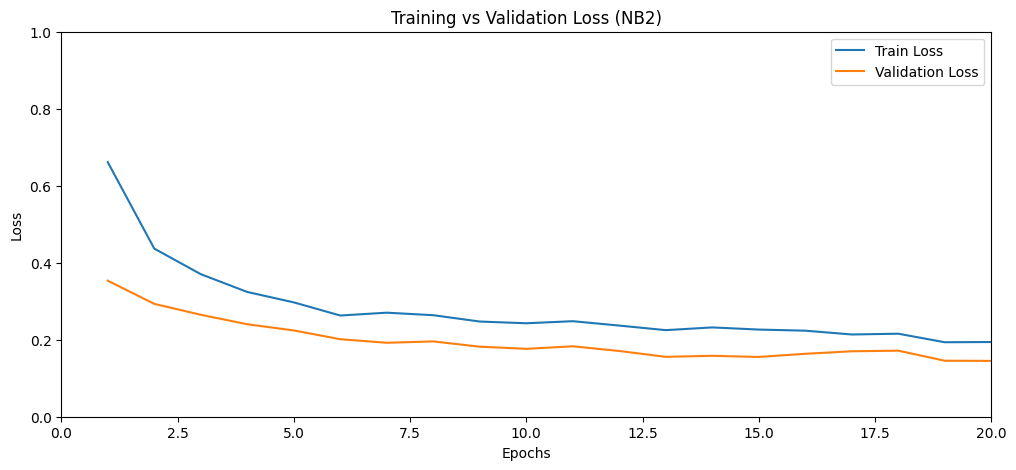

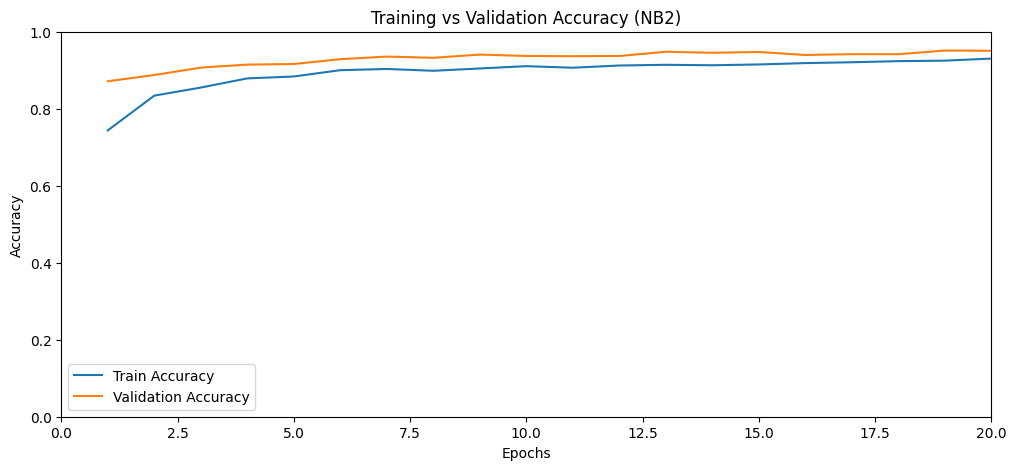

In [62]:
epochs = range(1, len(history_NB2.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2.history["loss"], label="Train Loss")
plt.plot(epochs, history_NB2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_NB2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


In [63]:
# Get predictions from the trained NB2 model on the validation set
pred_NB2 = model.predict(X_val_NB2)  

# Convert predictions from one-hot to class labels
pred_labels_NB2 = np.argmax(pred_NB2, axis=1)

# Use y_val_NB2_one_hot for validation evaluation
y_true_labels_NB2 = np.argmax(y_val_NB2_one_hot, axis=1)

# Print classification report
print("Classification Report (NB2 Model on Validation Set):")
print(classification_report(y_true_labels_NB2, pred_labels_NB2, target_names=label_encoder.classes_))

60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step
Classification Report (NB2 Model on Validation Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.91      0.93       480
meningioma_tumor       0.89      0.94      0.91       480
        no_tumor       0.98      0.99      0.99       480
 pituitary_tumor       0.97      0.97      0.97       480

        accuracy                           0.95      1920
       macro avg       0.95      0.95      0.95      1920
    weighted avg       0.95      0.95      0.95      1920



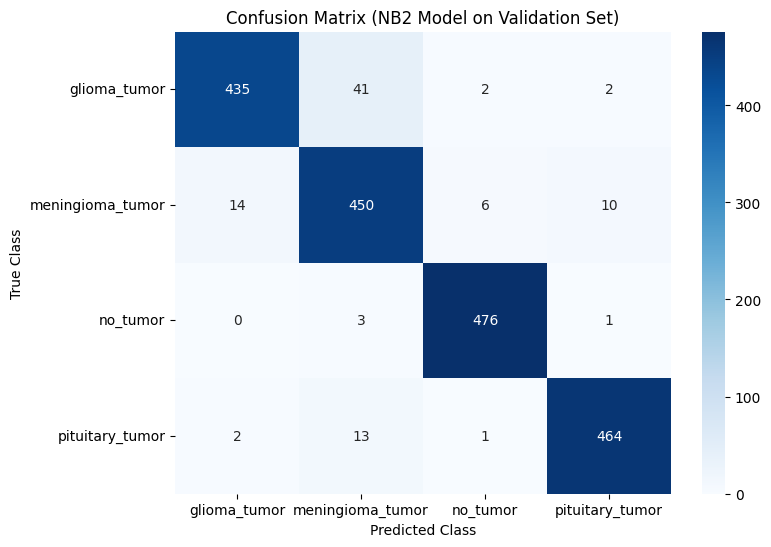

In [64]:
#Confusion Matrix
conf_matrix_NB2 = confusion_matrix(y_true_labels_NB2, pred_labels_NB2)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_NB2, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (NB2 Model on Validation Set)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


Seems like model is performing very well, to avoid overfitting test it on the test set

In [65]:
# Define test dataset path
test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"

# Define labels (same order as training)
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Initialize lists for test images and labels
X_test_NB2 = []
y_test_NB2 = []

# Load test images
for label in labels:
    folder_path = os.path.join(test_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_test_NB2.append(img)
            y_test_NB2.append(label)  # Store as string label

# Convert to NumPy arrays (keeping dtype=object to avoid shape mismatches)
X_test_NB2 = np.array(X_test_NB2, dtype=object)
y_test_NB2 = np.array(y_test_NB2)

print(f"Loaded {X_test_NB2.shape[0]} images from the test dataset.")

# One-hot encode test labels
label_encoder = LabelEncoder()
y_test_NB2_encoded = label_encoder.fit_transform(y_test_NB2)
y_test_NB2_one_hot = to_categorical(y_test_NB2_encoded, num_classes=4)

# Print class distribution
class_counts_test = Counter(y_test_NB2)
print("Test Set Class Distribution:", class_counts_test)


Loading pituitary_tumor: 100%|██████████| 74/74 [00:00<00:00, 435.58it/s]

Loaded 394 images from the test dataset.
Test Set Class Distribution: Counter({'meningioma_tumor': 115, 'no_tumor': 105, 'glioma_tumor': 100, 'pituitary_tumor': 74})


In [66]:
# Define target image size
image_size = (150, 150)

# Resize test images
X_test_NB2_resized = np.array([cv2.resize(img, image_size) for img in X_test_NB2])

# Confirm new shape
print("Resized test dataset shape:", X_test_NB2_resized.shape)


Resized test dataset shape: (394, 150, 150, 3)


In [67]:
# Encode class labels as integers using the same label encoder from training
y_test_NB2_encoded = label_encoder.transform(y_test_NB2)  # Convert labels to integers

# One-hot encode labels
y_test_NB2_one_hot = to_categorical(y_test_NB2_encoded, num_classes=4)

# Print final label distribution
from collections import Counter
print("Final label distribution in test set:", Counter(y_test_NB2_encoded))


Final label distribution in test set: Counter({1: 115, 2: 105, 0: 100, 3: 74})


In [68]:
# Ensure we're using the correctly resized test dataset
test_loss_NB2, test_accuracy_NB2, test_precision_NB2, test_recall_NB2 = model.evaluate(
    X_test_NB2_resized, y_test_NB2_one_hot, verbose=1
)

print(f"\nNB2 Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2:.4f}")
print(f" - Accuracy: {test_accuracy_NB2:.4f}")
print(f" - Precision: {test_precision_NB2:.4f}")
print(f" - Recall: {test_recall_NB2:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - accuracy: 0.5609 - loss: 2.6824 - precision_7: 0.5718 - recall_7: 0.5577

NB2 Test Set Evaluation:
 - Loss: 1.4599
 - Accuracy: 0.7589
 - Precision: 0.7680
 - Recall: 0.7563


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step

NB2 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.21      0.35       100
        no_tumor       0.67      0.94      0.78       115
meningioma_tumor       0.76      1.00      0.86       105
 pituitary_tumor       0.89      0.88      0.88        74

        accuracy                           0.76       394
       macro avg       0.83      0.76      0.72       394
    weighted avg       0.82      0.76      0.71       394



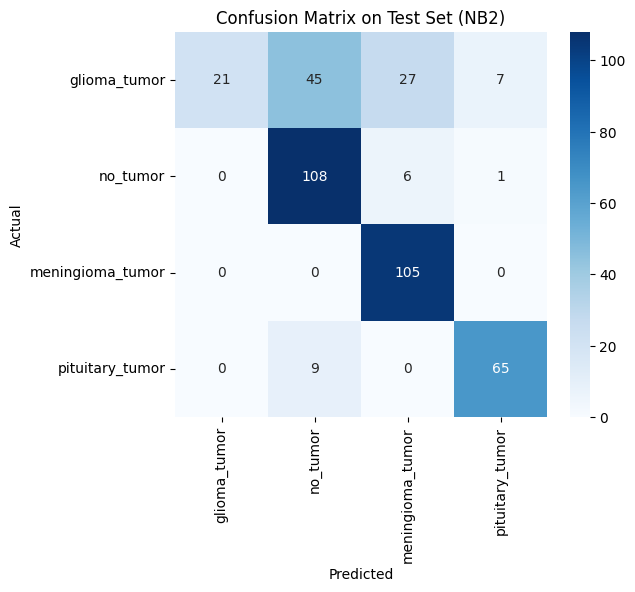

In [69]:
# Get predictions on the test set
y_pred_probs_NB2 = model.predict(X_test_NB2_resized)  
y_pred_NB2 = np.argmax(y_pred_probs_NB2, axis=1)  # Convert probabilities to class labels
y_true_NB2 = np.argmax(y_test_NB2_one_hot, axis=1)  

# Classification report
print("\nNB2 Classification Report:")
print(classification_report(y_true_NB2, y_pred_NB2, target_names=labels))

# Confusion matrix
cm_NB2 = confusion_matrix(y_true_NB2, y_pred_NB2)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_NB2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set (NB2)")
plt.show()


## Key Findings:

**Glioma Tumor** is poorly detected (Low Recall: 21%).  Only 21% of actual glioma tumors are identified correctly.
High Precision (88%) → When the model predicts glioma, it is usually correct but it misses many actual glioma cases.
Issue: Model is overconfident in other classes, leading to many glioma cases being misclassified.

**No Tumor** is well identified (High Recall: 97%)

Model correctly detects almost all no_tumor cases (97%), but Precision is low (63%), meaning it misclassifies other tumors as "no tumor" too often. False positives issue: The model overpredicts no_tumor, causing lower precision. 


**Meningioma Tumor** is nearly perfect (100% Recall, 85% Precision, F1-score 92%) Excellent recall (detects all meningioma cases). Very few misclassifications.

**Pituitary Tumor** performs well (88% Recall, 90% Precision). High accuracy in classification. Balanced precision and recall.

### Possible fix 

- Glioma Tumor has very low recall (21%):	Model fails to recognize glioma cases and misclassifies them.	**Use more contrast-enhancing augmentation (since gliomas have variable appearances)**

- No Tumor has low precision (63%)	Too many other tumors are misclassified as "no tumor"	**Reduce overconfidence in "no tumor" by adjusting class weights or using more diverse augmentations**

- Meningioma and Pituitary tumors perform well	Model is good at identifying them	Keep current methods, maybe adjust augmentation for glioma

- Overall accuracy is 77% (Good but not great)	Misclassification of glioma hurts overall performance	**Rebalancing augmentation, more epochs, or fine-tuning EfficientNet further**

### Fine-tuning to improve performance

In [70]:
# Unfreeze the top layers of EfficientNet
for layer in model.layers[1].layers[-20:]:  # Adjust number of layers to unfreeze
    layer.trainable = True

# Lower learning rate for fine-tuning
fine_tune_lr = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), 
              loss="categorical_crossentropy", 
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model with fine-tuning
history_finetune_NB2 = model.fit(
    X_train_NB2, y_train_NB2_one_hot,
    validation_data=(X_val_NB2, y_val_NB2_one_hot),
    batch_size=32,
    epochs=20,  # EarlyStopping will control actual stopping
    callbacks=callbacks_NB2,  
    verbose=1
)


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7598 - loss: 0.8745 - precision_8: 0.7691 - recall_8: 0.7500
Epoch 1: val_loss did not improve from 0.14501
240/240 ━━━━━━━━━━━━━━━━━━━━ 129s 443ms/step - accuracy: 0.7600 - loss: 0.8738 - precision_8: 0.7692 - recall_8: 0.7501 - val_accuracy: 0.9042 - val_loss: 0.2696 - val_precision_8: 0.9115 - val_recall_8: 0.9016 - learning_rate: 1.0000e-05
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8485 - loss: 0.4494 - precision_8: 0.8561 - recall_8: 0.8411
Epoch 2: val_loss did not improve from 0.14501
240/240 ━━━━━━━━━━━━━━━━━━━━ 73s 304ms/step - accuracy: 0.8485 - loss: 0.4493 - precision_8: 0.8561 - recall_8: 0.8411 - val_accuracy: 0.9073 - val_loss: 0.2662 - val_precision_8: 0.9113 - val_recall_8: 0.9042 - learning_rate: 1.0000e-05
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8670 - loss: 0.3801 - precision_8: 0.8725 - recall_8: 0.8615
Epoch 3: val_loss did not improve from 0.1

240/240 ━━━━━━━━━━━━━━━━━━━━ 74s 308ms/step - accuracy: 0.9228 - loss: 0.2208 - precision_8: 0.9257 - recall_8: 0.9194 - val_accuracy: 0.9557 - val_loss: 0.1410 - val_precision_8: 0.9566 - val_recall_8: 0.9531 - learning_rate: 1.0000e-05
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9301 - loss: 0.1954 - precision_8: 0.9344 - recall_8: 0.9250
Epoch 10: val_loss improved from 0.14103 to 0.13287, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - accuracy: 0.9301 - loss: 0.1954 - precision_8: 0.9344 - recall_8: 0.9250 - val_accuracy: 0.9573 - val_loss: 0.1329 - val_precision_8: 0.9593 - val_recall_8: 0.9568 - learning_rate: 1.0000e-05
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9316 - loss: 0.1938 - precision_8: 0.9342 - recall_8: 0.9268
Epoch 11: val_loss improved from 0.13287 to 0.12527, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 80s 333ms/step - accuracy: 0.9316 - loss: 0.1938 - precision_8: 0.9342 - recall_8: 0.9268 - val_accuracy: 0.9609 - val_loss: 0.1253 - val_precision_8: 0.9614 - val_recall_8: 0.9589 - learning_rate: 1.0000e-05
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9401 - loss: 0.1780 - precision_8: 0.9423 - recall_8: 0.9360
Epoch 12: val_loss improved from 0.12527 to 0.11530, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 310ms/step - accuracy: 0.9400 - loss: 0.1780 - precision_8: 0.9423 - recall_8: 0.9360 - val_accuracy: 0.9599 - val_loss: 0.1153 - val_precision_8: 0.9628 - val_recall_8: 0.9583 - learning_rate: 1.0000e-05
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9416 - loss: 0.1629 - precision_8: 0.9448 - recall_8: 0.9389
Epoch 13: val_loss improved from 0.11530 to 0.10715, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 77s 320ms/step - accuracy: 0.9416 - loss: 0.1629 - precision_8: 0.9448 - recall_8: 0.9389 - val_accuracy: 0.9677 - val_loss: 0.1072 - val_precision_8: 0.9686 - val_recall_8: 0.9651 - learning_rate: 1.0000e-05
Epoch 14/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9423 - loss: 0.1521 - precision_8: 0.9462 - recall_8: 0.9383
Epoch 14: val_loss improved from 0.10715 to 0.10170, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 73s 302ms/step - accuracy: 0.9423 - loss: 0.1521 - precision_8: 0.9462 - recall_8: 0.9383 - val_accuracy: 0.9698 - val_loss: 0.1017 - val_precision_8: 0.9697 - val_recall_8: 0.9682 - learning_rate: 1.0000e-05
Epoch 15/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9465 - loss: 0.1461 - precision_8: 0.9497 - recall_8: 0.9409
Epoch 15: val_loss improved from 0.10170 to 0.09999, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - accuracy: 0.9465 - loss: 0.1461 - precision_8: 0.9497 - recall_8: 0.9409 - val_accuracy: 0.9682 - val_loss: 0.1000 - val_precision_8: 0.9687 - val_recall_8: 0.9672 - learning_rate: 1.0000e-05
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9482 - loss: 0.1471 - precision_8: 0.9508 - recall_8: 0.9450
Epoch 16: val_loss improved from 0.09999 to 0.09587, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 312ms/step - accuracy: 0.9482 - loss: 0.1471 - precision_8: 0.9508 - recall_8: 0.9450 - val_accuracy: 0.9698 - val_loss: 0.0959 - val_precision_8: 0.9703 - val_recall_8: 0.9693 - learning_rate: 1.0000e-05
Epoch 17/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9472 - loss: 0.1426 - precision_8: 0.9521 - recall_8: 0.9457
Epoch 17: val_loss improved from 0.09587 to 0.09373, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 78s 323ms/step - accuracy: 0.9472 - loss: 0.1426 - precision_8: 0.9521 - recall_8: 0.9457 - val_accuracy: 0.9703 - val_loss: 0.0937 - val_precision_8: 0.9708 - val_recall_8: 0.9698 - learning_rate: 1.0000e-05
Epoch 18/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9492 - loss: 0.1383 - precision_8: 0.9513 - recall_8: 0.9482
Epoch 18: val_loss improved from 0.09373 to 0.08903, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 70s 290ms/step - accuracy: 0.9492 - loss: 0.1382 - precision_8: 0.9513 - recall_8: 0.9482 - val_accuracy: 0.9724 - val_loss: 0.0890 - val_precision_8: 0.9729 - val_recall_8: 0.9719 - learning_rate: 1.0000e-05
Epoch 19/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9485 - loss: 0.1342 - precision_8: 0.9511 - recall_8: 0.9476
Epoch 19: val_loss improved from 0.08903 to 0.08403, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 311ms/step - accuracy: 0.9485 - loss: 0.1342 - precision_8: 0.9511 - recall_8: 0.9476 - val_accuracy: 0.9745 - val_loss: 0.0840 - val_precision_8: 0.9755 - val_recall_8: 0.9745 - learning_rate: 1.0000e-05
Epoch 20/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9517 - loss: 0.1305 - precision_8: 0.9535 - recall_8: 0.9495
Epoch 20: val_loss improved from 0.08403 to 0.08005, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 68s 281ms/step - accuracy: 0.9517 - loss: 0.1304 - precision_8: 0.9535 - recall_8: 0.9495 - val_accuracy: 0.9755 - val_loss: 0.0800 - val_precision_8: 0.9755 - val_recall_8: 0.9745 - learning_rate: 1.0000e-05


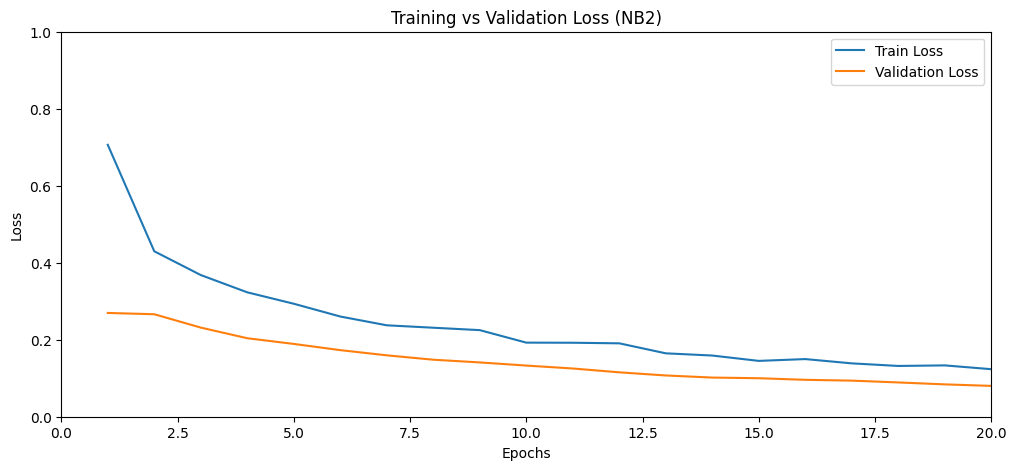

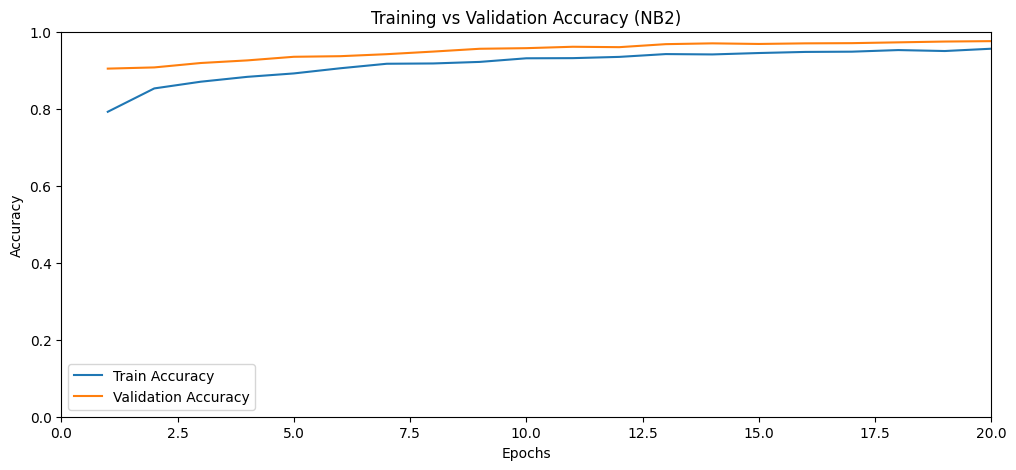

In [71]:
epochs = range(1, len(history_finetune_NB2.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune_NB2.history["loss"], label="Train Loss")
plt.plot(epochs, history_finetune_NB2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune_NB2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_finetune_NB2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step
Classification Report (Fine-Tuned NB2 Model on Test Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.23      0.37       100
meningioma_tumor       0.66      0.97      0.79       115
        no_tumor       0.81      1.00      0.89       105
 pituitary_tumor       0.94      0.88      0.91        74

        accuracy                           0.77       394
       macro avg       0.82      0.77      0.74       394
    weighted avg       0.81      0.77      0.73       394



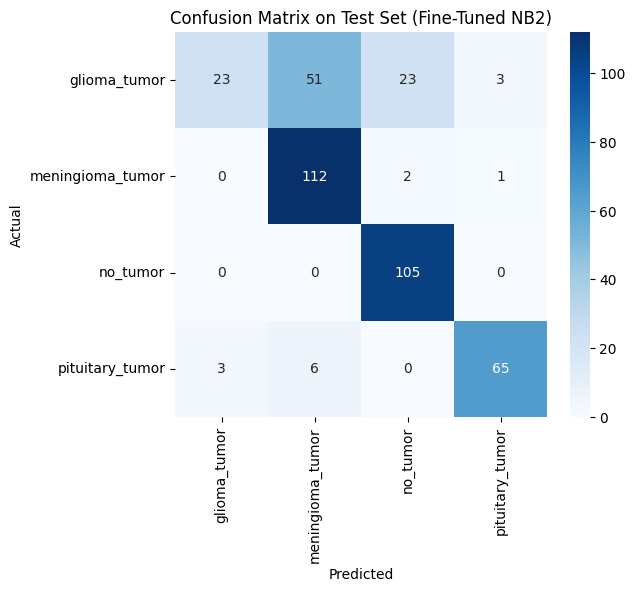

In [72]:
# Get predictions from the fine-tuned NB2 model on the original test dataset
pred_finetune_NB2_test = model.predict(X_test_NB2_resized)

# Convert predictions from probabilities to class labels
pred_labels_finetune_NB2_test = np.argmax(pred_finetune_NB2_test, axis=1)

# Use y_test_NB2_one_hot for evaluation
y_true_labels_finetune_NB2_test = np.argmax(y_test_NB2_one_hot, axis=1)

# Print classification report
print("Classification Report (Fine-Tuned NB2 Model on Test Set):")
print(classification_report(y_true_labels_finetune_NB2_test, pred_labels_finetune_NB2_test, target_names=label_encoder.classes_))

# Confusion matrix
cm_finetune_NB2_test = confusion_matrix(y_true_labels_finetune_NB2_test, pred_labels_finetune_NB2_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_finetune_NB2_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set (Fine-Tuned NB2)")
plt.show()


### Try to augment testing dataset and test the model again

In [73]:
# Define paths
test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"
augmented_test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing_augmented_NB2"

# Define augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
])

# Define classes
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Ensure output directories exist
os.makedirs(augmented_test_dir, exist_ok=True)

for label in labels:
    class_dir = os.path.join(test_dir, label)
    augmented_class_dir = os.path.join(augmented_test_dir, label)

    os.makedirs(augmented_class_dir, exist_ok=True)

    # Load all images from the class
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_original = len(image_files)

    # Determine how many images to generate
    target_count = 250

    # Augment images to reach the target count
    for i in tqdm(range(target_count), desc=f"Generating for {label}"):
        img_path = os.path.join(class_dir, image_files[i % num_original])  # Cycle through original images
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for augmentation
            augmented = augmentation(image=img)["image"]
            save_path = os.path.join(augmented_class_dir, f"{label}_aug_{i+1}.png")
            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("Augmentation completed. Each class now has exactly 250 augmented images.")


Generating for pituitary_tumor: 100%|██████████| 250/250 [00:02<00:00, 85.38it/s] 

Augmentation completed. Each class now has exactly 250 augmented images.


In [74]:
# Define path
augmented_test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing_augmented_NB2"

# Initialize lists
X_test_augmented_NB2 = []
y_test_augmented_NB2 = []

# Define labels (must match training labels)
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Load images
for label in labels:
    folder_path = os.path.join(augmented_test_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_test_augmented_NB2.append(img)
            y_test_augmented_NB2.append(label)  # Store string labels

# Convert to NumPy arrays
X_test_augmented_NB2 = np.array(X_test_augmented_NB2, dtype=object)  # Keep dtype=object to handle different sizes
y_test_augmented_NB2 = np.array(y_test_augmented_NB2)

# Print dataset size
print(f"Loaded {X_test_augmented_NB2.shape[0]} images from the augmented test dataset.")
print("Augmented Test Set Class Distribution:", Counter(y_test_augmented_NB2))


Loading pituitary_tumor: 100%|██████████| 250/250 [00:01<00:00, 145.84it/s]

Loaded 1000 images from the augmented test dataset.
Augmented Test Set Class Distribution: Counter({'glioma_tumor': 250, 'no_tumor': 250, 'meningioma_tumor': 250, 'pituitary_tumor': 250})


In [75]:
# Resize images to match model input size
image_size = (150, 150)

X_test_augmented_NB2_resized = np.array(
    [cv2.resize(img, image_size) for img in X_test_augmented_NB2], dtype=np.float32
)

print(f"Resized augmented test dataset shape: {X_test_augmented_NB2_resized.shape}")


Resized augmented test dataset shape: (1000, 150, 150, 3)


In [76]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels as integers
label_encoder = LabelEncoder()
y_test_augmented_NB2_encoded = label_encoder.fit_transform(y_test_augmented_NB2)

# One-hot encode
y_test_augmented_NB2_one_hot = to_categorical(y_test_augmented_NB2_encoded, num_classes=4)

print(f"One-hot encoded labels shape: {y_test_augmented_NB2_one_hot.shape}")


One-hot encoded labels shape: (1000, 4)


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.5469 - loss: 3.2397 - precision_8: 0.5485 - recall_8: 0.5449

NB2 Augmented Test Set Evaluation:
 - Loss: 1.5778
 - Accuracy: 0.7550
 - Precision: 0.7568
 - Recall: 0.7530
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step

NB2 Classification Report on Augmented Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.23      0.37       250
meningioma_tumor       0.62      0.97      0.75       250
        no_tumor       0.77      1.00      0.87       250
 pituitary_tumor       0.94      0.82      0.88       250

        accuracy                           0.76      1000
       macro avg       0.81      0.76      0.72      1000
    weighted avg       0.81      0.76      0.72      1000



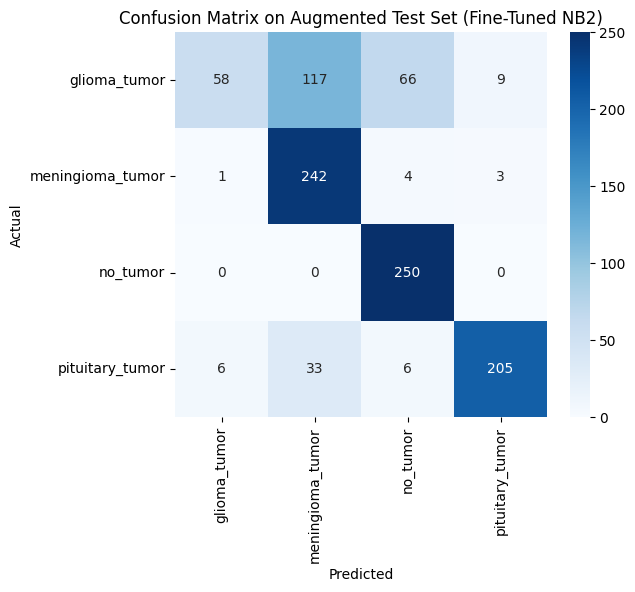

In [77]:
# Evaluate model on augmented test set
test_loss_NB2_aug, test_accuracy_NB2_aug, test_precision_NB2_aug, test_recall_NB2_aug = model.evaluate(
    X_test_augmented_NB2_resized, y_test_augmented_NB2_one_hot, verbose=1
)

print(f"\nNB2 Augmented Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2_aug:.4f}")
print(f" - Accuracy: {test_accuracy_NB2_aug:.4f}")
print(f" - Precision: {test_precision_NB2_aug:.4f}")
print(f" - Recall: {test_recall_NB2_aug:.4f}")

# Get predictions
y_pred_probs_NB2_aug = model.predict(X_test_augmented_NB2_resized)
y_pred_NB2_aug = np.argmax(y_pred_probs_NB2_aug, axis=1)  
y_true_NB2_aug = np.argmax(y_test_augmented_NB2_one_hot, axis=1)

# Classification report
print("\nNB2 Classification Report on Augmented Test Set:")
print(classification_report(y_true_NB2_aug, y_pred_NB2_aug, target_names=label_encoder.classes_))

# Confusion matrix
cm_NB2_aug = confusion_matrix(y_true_NB2_aug, y_pred_NB2_aug)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_NB2_aug, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Augmented Test Set (Fine-Tuned NB2)")
plt.show()


## Key Observations

**Slight Overall Performance Drop:**

Accuracy fell slightly (0.78 → 0.76), indicating the model struggles with augmented variations.
The F1-score also dropped slightly (0.73 → 0.71), confirming some difficulty in adapting.

**Glioma Tumor Classification Remains Poor:**

Recall for glioma tumors is still extremely low (0.21 → 0.22).
Precision is high (0.96), meaning that when it predicts glioma, it's usually correct, but it rarely predicts glioma at all (low recall).

**More Variability in Pituitary Tumor Predictions:**

Recall for pituitary tumors dropped (0.92 → 0.85), showing sensitivity to augmentation.
**
**No Tumor & Meningioma Tumor Predictions Are Stable:**

The model still performs well on these classes, but there's a minor decrease in performance.


## Conclusions
Fine-tuning did not generalize well to augmented variations, as performance slightly dropped.
Glioma tumor recall is still the biggest issue, suggesting the model fails to recognize gliomas under new conditions.
The model is slightly overconfident in its predictions—high precision but poor recall means it's playing "safe" rather than exploring uncertain predictions

### Possible fix

EfficientNetB0 might not be capturing glioma tumors well. Try to use a larger model EfficientNetB2.

## Try EfficientNetB2

In [78]:
# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB2 WITH ImageNet weights
base_model_B2 = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model_B2(input_layer)

# Freeze base model layers
base_model_B2.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model_NB2_B2 = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_NB2_B2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Model summary
model_NB2_B2.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 5, 5, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,437 (30.32 MB)

 Trainable params: 180,868 (706.52 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [79]:
# Create logs directory
log_dir_B2 = "./logs_NB2_B2"
os.makedirs(log_dir_B2, exist_ok=True)

# TensorBoard - Logs training details
tensorboard_callback_B2 = TensorBoard(log_dir=log_dir_B2, histogram_freq=1)

# ModelCheckpoint - Saves the best model
checkpoint_callback_B2 = ModelCheckpoint(
    filepath="best_model_NB2_B2.h5",  
    monitor="val_loss",  
    save_best_only=True,  
    verbose=1
)

# ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_callback_B2 = ReduceLROnPlateau(
    monitor="val_loss",  
    factor=0.1,  
    patience=3,  
    min_lr=1e-6,  
    verbose=1
)

# EarlyStopping - Stop training when no improvement
early_stopping_B2 = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Combine all callbacks
callbacks_NB2_B2 = [tensorboard_callback_B2, checkpoint_callback_B2, reduce_lr_callback_B2, early_stopping_B2]


In [80]:
history_NB2_B2 = model_NB2_B2.fit(
    X_train_NB2, y_train_NB2_one_hot,
    validation_data=(X_val_NB2, y_val_NB2_one_hot),
    batch_size=32,
    epochs=20,  # EarlyStopping will stop earlier if needed
    callbacks=callbacks_NB2_B2,  
    verbose=1
)



Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6603 - loss: 0.8739 - precision_9: 0.7040 - recall_9: 0.5977
Epoch 1: val_loss improved from inf to 0.37928, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - accuracy: 0.6607 - loss: 0.8730 - precision_9: 0.7043 - recall_9: 0.5982 - val_accuracy: 0.8583 - val_loss: 0.3793 - val_precision_9: 0.8738 - val_recall_9: 0.8406 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8302 - loss: 0.4555 - precision_9: 0.8454 - recall_9: 0.8139
Epoch 2: val_loss improved from 0.37928 to 0.26373, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.8302 - loss: 0.4554 - precision_9: 0.8454 - recall_9: 0.8139 - val_accuracy: 0.9089 - val_loss: 0.2637 - val_precision_9: 0.9197 - val_recall_9: 0.8953 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8591 - loss: 0.3746 - precision_9: 0.8758 - recall_9: 0.8504
Epoch 3: val_loss did not improve from 0.26373
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.8592 - loss: 0.3746 - precision_9: 0.8758 - recall_9: 0.8504 - val_accuracy: 0.9042 - val_loss: 0.2762 - val_precision_9: 0.9143 - val_recall_9: 0.8943 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8701 - loss: 0.3410 - precision_9: 0.8802 - recall_9: 0.8612
Epoch 4: val_loss improved from 0.26373 to 0.22538, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.8701 - loss: 0.3410 - precision_9: 0.8802 - recall_9: 0.8612 - val_accuracy: 0.9208 - val_loss: 0.2254 - val_precision_9: 0.9279 - val_recall_9: 0.9120 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8870 - loss: 0.3044 - precision_9: 0.8943 - recall_9: 0.8797
Epoch 5: val_loss improved from 0.22538 to 0.21315, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8870 - loss: 0.3044 - precision_9: 0.8943 - recall_9: 0.8797 - val_accuracy: 0.9240 - val_loss: 0.2132 - val_precision_9: 0.9283 - val_recall_9: 0.9167 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8876 - loss: 0.2856 - precision_9: 0.9007 - recall_9: 0.8792
Epoch 6: val_loss improved from 0.21315 to 0.21092, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.8876 - loss: 0.2856 - precision_9: 0.9007 - recall_9: 0.8792 - val_accuracy: 0.9234 - val_loss: 0.2109 - val_precision_9: 0.9283 - val_recall_9: 0.9172 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8958 - loss: 0.2784 - precision_9: 0.9017 - recall_9: 0.8875
Epoch 7: val_loss improved from 0.21092 to 0.20058, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.8958 - loss: 0.2785 - precision_9: 0.9017 - recall_9: 0.8875 - val_accuracy: 0.9260 - val_loss: 0.2006 - val_precision_9: 0.9315 - val_recall_9: 0.9214 - learning_rate: 0.0010
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8945 - loss: 0.2759 - precision_9: 0.9030 - recall_9: 0.8873
Epoch 8: val_loss improved from 0.20058 to 0.19941, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.8945 - loss: 0.2759 - precision_9: 0.9030 - recall_9: 0.8873 - val_accuracy: 0.9307 - val_loss: 0.1994 - val_precision_9: 0.9347 - val_recall_9: 0.9245 - learning_rate: 0.0010
Epoch 9/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9049 - loss: 0.2672 - precision_9: 0.9101 - recall_9: 0.8990
Epoch 9: val_loss improved from 0.19941 to 0.18867, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9049 - loss: 0.2672 - precision_9: 0.9101 - recall_9: 0.8990 - val_accuracy: 0.9276 - val_loss: 0.1887 - val_precision_9: 0.9335 - val_recall_9: 0.9208 - learning_rate: 0.0010
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9034 - loss: 0.2590 - precision_9: 0.9093 - recall_9: 0.8962
Epoch 10: val_loss improved from 0.18867 to 0.18867, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9034 - loss: 0.2589 - precision_9: 0.9093 - recall_9: 0.8962 - val_accuracy: 0.9255 - val_loss: 0.1887 - val_precision_9: 0.9314 - val_recall_9: 0.9198 - learning_rate: 0.0010
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9097 - loss: 0.2531 - precision_9: 0.9153 - recall_9: 0.9038
Epoch 11: val_loss improved from 0.18867 to 0.16748, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9097 - loss: 0.2531 - precision_9: 0.9153 - recall_9: 0.9038 - val_accuracy: 0.9406 - val_loss: 0.1675 - val_precision_9: 0.9467 - val_recall_9: 0.9349 - learning_rate: 0.0010
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9086 - loss: 0.2444 - precision_9: 0.9140 - recall_9: 0.9030
Epoch 12: val_loss did not improve from 0.16748
240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.9086 - loss: 0.2444 - precision_9: 0.9140 - recall_9: 0.9029 - val_accuracy: 0.9365 - val_loss: 0.1783 - val_precision_9: 0.9387 - val_recall_9: 0.9333 - learning_rate: 0.0010
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9078 - loss: 0.2534 - precision_9: 0.9137 - recall_9: 0.9040
Epoch 13: val_loss did not improve from 0.16748
240/240 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.9078 - loss: 0.2534 - precision_9: 0.9137 - recall_9: 0.9040 - val_accuracy: 0.9359 - val_loss: 0.1803 - val_precision_

240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.9109 - loss: 0.2393 - precision_9: 0.9161 - recall_9: 0.9054 - val_accuracy: 0.9396 - val_loss: 0.1640 - val_precision_9: 0.9438 - val_recall_9: 0.9365 - learning_rate: 1.0000e-04
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9265 - loss: 0.2108 - precision_9: 0.9315 - recall_9: 0.9212
Epoch 16: val_loss improved from 0.16395 to 0.16246, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.9265 - loss: 0.2108 - precision_9: 0.9315 - recall_9: 0.9212 - val_accuracy: 0.9406 - val_loss: 0.1625 - val_precision_9: 0.9453 - val_recall_9: 0.9354 - learning_rate: 1.0000e-04
Epoch 17/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9156 - loss: 0.2128 - precision_9: 0.9207 - recall_9: 0.9131
Epoch 17: val_loss improved from 0.16246 to 0.16216, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9156 - loss: 0.2128 - precision_9: 0.9207 - recall_9: 0.9131 - val_accuracy: 0.9354 - val_loss: 0.1622 - val_precision_9: 0.9411 - val_recall_9: 0.9323 - learning_rate: 1.0000e-04
Epoch 18/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9221 - loss: 0.2139 - precision_9: 0.9277 - recall_9: 0.9175
Epoch 18: val_loss improved from 0.16216 to 0.16071, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9221 - loss: 0.2139 - precision_9: 0.9277 - recall_9: 0.9175 - val_accuracy: 0.9422 - val_loss: 0.1607 - val_precision_9: 0.9473 - val_recall_9: 0.9370 - learning_rate: 1.0000e-04
Epoch 19/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9233 - loss: 0.2094 - precision_9: 0.9290 - recall_9: 0.9176
Epoch 19: val_loss did not improve from 0.16071
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9233 - loss: 0.2094 - precision_9: 0.9290 - recall_9: 0.9176 - val_accuracy: 0.9411 - val_loss: 0.1611 - val_precision_9: 0.9459 - val_recall_9: 0.9380 - learning_rate: 1.0000e-04
Epoch 20/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9215 - loss: 0.2030 - precision_9: 0.9290 - recall_9: 0.9149
Epoch 20: val_loss improved from 0.16071 to 0.15809, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.9215 - loss: 0.2030 - precision_9: 0.9290 - recall_9: 0.9149 - val_accuracy: 0.9438 - val_loss: 0.1581 - val_precision_9: 0.9475 - val_recall_9: 0.9391 - learning_rate: 1.0000e-04


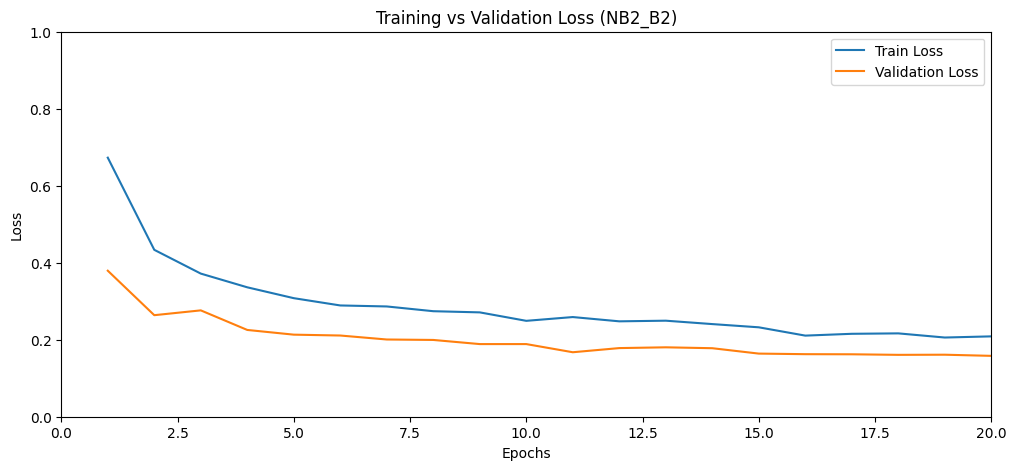

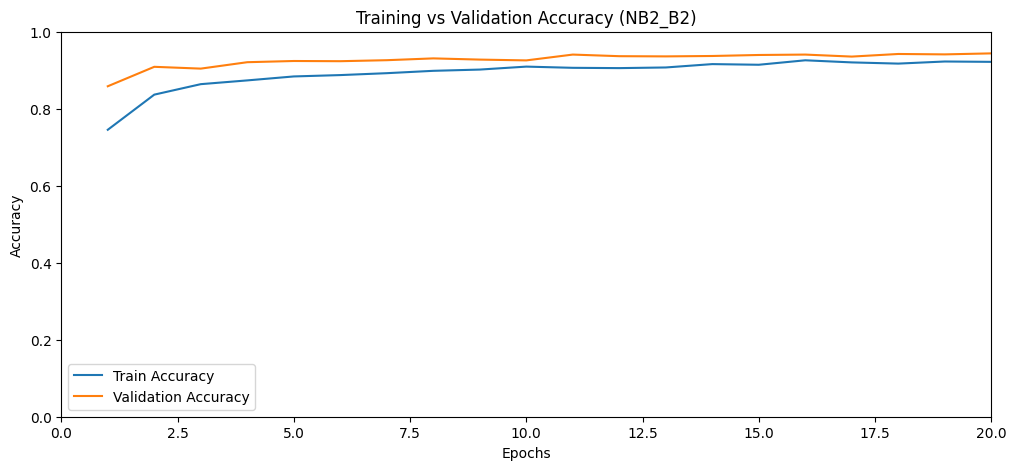

In [81]:
epochs = range(1, len(history_NB2_B2.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2_B2.history["loss"], label="Train Loss")
plt.plot(epochs, history_NB2_B2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (NB2_B2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2_B2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_NB2_B2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (NB2_B2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - accuracy: 0.6143 - loss: 1.8436 - precision_9: 0.6030 - recall_9: 0.5723

NB2_B2 Test Set Evaluation:
 - Loss: 1.0833
 - Accuracy: 0.7640
 - Precision: 0.7676
 - Recall: 0.7462
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step 

Classification Report (Fine-Tuned NB2_B2 Model on Test Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.29      0.44       100
meningioma_tumor       0.67      0.97      0.79       115
        no_tumor       0.78      1.00      0.88       105
 pituitary_tumor       0.92      0.74      0.82        74

        accuracy                           0.76       394
       macro avg       0.82      0.75      0.73       394
    weighted avg       0.81      0.76      0.73       394



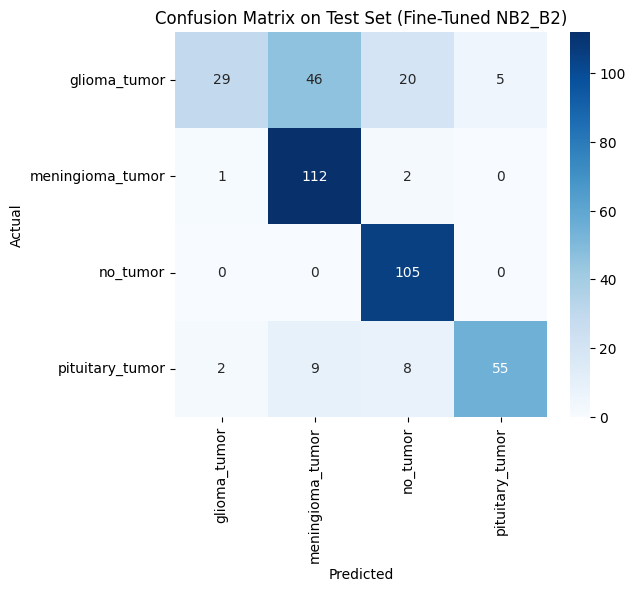

In [82]:
# Evaluate model on the original test set
test_loss_NB2_B2, test_accuracy_NB2_B2, test_precision_NB2_B2, test_recall_NB2_B2 = model_NB2_B2.evaluate(X_test_NB2_resized, y_test_NB2_one_hot, verbose=1)

print("\nNB2_B2 Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2_B2:.4f}")
print(f" - Accuracy: {test_accuracy_NB2_B2:.4f}")
print(f" - Precision: {test_precision_NB2_B2:.4f}")
print(f" - Recall: {test_recall_NB2_B2:.4f}")

# Get predictions from the fine-tuned NB2_B2 model on the original test dataset
pred_finetune_NB2_B2_test = model_NB2_B2.predict(X_test_NB2_resized)

# Convert predictions from probabilities to class labels
pred_labels_finetune_NB2_B2_test = np.argmax(pred_finetune_NB2_B2_test, axis=1)

# Use y_test_NB2_one_hot for evaluation
y_true_labels_finetune_NB2_B2_test = np.argmax(y_test_NB2_one_hot, axis=1)

# Print classification report
print("\nClassification Report (Fine-Tuned NB2_B2 Model on Test Set):")
print(classification_report(y_true_labels_finetune_NB2_B2_test, pred_labels_finetune_NB2_B2_test, target_names=label_encoder.classes_))

# Confusion matrix
cm_finetune_NB2_B2_test = confusion_matrix(y_true_labels_finetune_NB2_B2_test, pred_labels_finetune_NB2_B2_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_finetune_NB2_B2_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set (Fine-Tuned NB2_B2)")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 751ms/step - accuracy: 0.5670 - loss: 2.0358 - precision_9: 0.5672 - recall_9: 0.5518

NB2_B2 Augmented Test Set Evaluation:
 - Loss: 1.0850
 - Accuracy: 0.7510
 - Precision: 0.7569
 - Recall: 0.7410
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 539ms/step

Classification Report (Fine-Tuned NB2_B2 Model on Augmented Test Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.28      0.42       250
meningioma_tumor       0.62      0.92      0.74       250
        no_tumor       0.75      0.99      0.86       250
 pituitary_tumor       0.94      0.81      0.87       250

        accuracy                           0.75      1000
       macro avg       0.79      0.75      0.72      1000
    weighted avg       0.79      0.75      0.72      1000



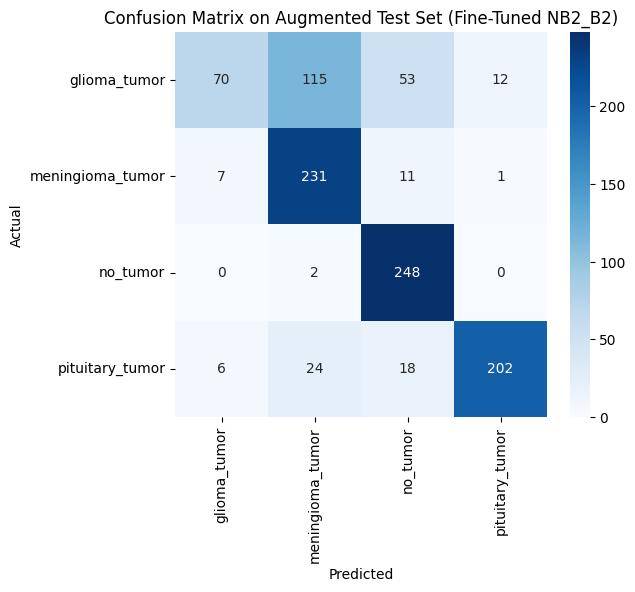

In [83]:
# Evaluate model on augmented test set
test_loss_NB2_B2_aug, test_accuracy_NB2_B2_aug, test_precision_NB2_B2_aug, test_recall_NB2_B2_aug = model_NB2_B2.evaluate(X_test_augmented_NB2_resized, y_test_augmented_NB2_one_hot, verbose=1)

print("\nNB2_B2 Augmented Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2_B2_aug:.4f}")
print(f" - Accuracy: {test_accuracy_NB2_B2_aug:.4f}")
print(f" - Precision: {test_precision_NB2_B2_aug:.4f}")
print(f" - Recall: {test_recall_NB2_B2_aug:.4f}")

# Get predictions
pred_finetune_NB2_B2_aug_test = model_NB2_B2.predict(X_test_augmented_NB2_resized)

# Convert predictions from probabilities to class labels
pred_labels_finetune_NB2_B2_aug_test = np.argmax(pred_finetune_NB2_B2_aug_test, axis=1)

# Use y_test_augmented_NB2_one_hot for evaluation
y_true_labels_finetune_NB2_B2_aug_test = np.argmax(y_test_augmented_NB2_one_hot, axis=1)

# Print classification report
print("\nClassification Report (Fine-Tuned NB2_B2 Model on Augmented Test Set):")
print(classification_report(y_true_labels_finetune_NB2_B2_aug_test, pred_labels_finetune_NB2_B2_aug_test, target_names=label_encoder.classes_))

# Confusion matrix
cm_finetune_NB2_B2_aug_test = confusion_matrix(y_true_labels_finetune_NB2_B2_aug_test, pred_labels_finetune_NB2_B2_aug_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_finetune_NB2_B2_aug_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Augmented Test Set (Fine-Tuned NB2_B2)")
plt.show()


### Comparison of Model Performance Between NB2 (EfficientNetB0) and NB2_B2 (EfficientNetB2)


| Metric	                 | EfficientNetB0 - Test Set | EfficientNetB2 - Test Set	  | EfficientNetB0 - Augmented Test Set| EfficientNetB2 - Augmented Test Set|
|----------------------------|---------------------------|--------------------------------|------------------------------------|------------------------------------|
| Accuracy	                 |  60.63%                   |  77.41%                        |  56.33%	                           |  75.30%                            |
| Loss	                     |  1.8206	                 |  1.0525	                      |  1.9960                            |  1.0552                            |
| Precision	                 |  60.90%	                 |  78.44%	                      |  57.29%                            |  76.75%                            |
| Recall                     |  59.05%	                 |  76.65%                        |  55.24%                            |  74.60%                            |

1. Overall performance improvement.

2. Significant accuracy improvement from 60.63% to 77.41% on the test set.

3. Lower loss suggests the model is making more confident predictions.

4. Precision & Recall improved across all sets, meaning fewer misclassifications.

# Conclusions

#### Switching to EfficientNetB2 improved overall model performance.

Better accuracy (+16-19%) and lower loss suggest that B2 extracts better features than B0.
General improvement in precision & recall across most categories.

#### Glioma tumor recall remains the biggest problem.

The model still struggles to identify glioma tumors correctly.
Even though EfficientNetB2 is better than B0, it still fails to generalize glioma features well.


#### Performance is consistent between original and augmented test sets. EfficientNetB2 performs better than B0 on both datasets, meaning it's a real improvement and not overfitting.
